<p><b><i>Основная цель и небольшое описание</i></b></p>
<p>Исследование является анализом маркетинговой стратегии приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Основная цель — разобраться в причинах и помочь компании выйти в плюс.</p>
<p><i>Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:</i></p>
<ul>
    <li>лог сервера с данными об их посещениях,</li>
    <li>выгрузка их покупок за этот период,</li>
    <li>рекламные расходы.</li>
</ul>

<p><i>Ход исследования:</i></p>
<ul>
<li> откуда приходят пользователи и какими устройствами они пользуются,</li>
<li> сколько стоит привлечение пользователей из различных рекламных каналов;</li>
<li> сколько денег приносит каждый клиент,</li>
<li> когда расходы на привлечение клиента окупаются,</li>
<li> какие факторы мешают привлечению клиентов.</li>
</ul>

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
# импорты
from datetime import datetime, timedelta
from dotenv import load_dotenv
from http import HTTPStatus
import os.path
import pandas as pd
import re
import requests
import seaborn as sns
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np
import warnings

load_dotenv()

# будем следить за поведением программы и за пользователями
# с помощью кастомного исключения на все случаи жизни
class BaseException(Exception):
    """Напишем базовое исключение"""

    def __init__(self, text):
        """активация..."""
        self.text = text

In [2]:
# баги - вечный леденец - соси его хоть круглый год, меньше не станет,
# но нужно их отлавливать, если я вдруг забуду поменяй, пожалуйста, level,
# должен быть - level=logging.INFO 

logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO)

# зачем себя лишний раз расстраивать?
warnings.filterwarnings('ignore')

In [3]:
PATH_ERROR_TEXT = 'некоррекнто прописан путь к данным'
def read_file(path_1: str, path_2: str) -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    # проверим, что файл существует, также стоит проверить
    # что это именно файл, если это не так, то нет смысла продолжать
    if (os.path.exists(path_1) and os.path.isfile(path_1)) or requests.get(path_1).status_code == HTTPStatus.OK:
        logging.info('works online')
        data = pd.read_csv(path_1)
        logging.info('read file sucsess')
        return data
    elif os.path.exists(path_2) and os.path.isfile(path_2):
        logging.info('works lokaly')
        data = pd.read_csv(path_2)
        logging.info('read file sucsess')
        return data
    else:
        logging.critical(PATH_ERROR_TEXT)
        raise BaseException(PATH_ERROR_TEXT) and sys.exit()


def get_full_information(data):
    """
    Функция дает нам полное
    представление о данных
    """
    logging.info('первое представление о данных')
    for _ in [data.head(), data.describe(), data.info()]:
        display(_)
        print("*"*100)
    data.hist(figsize=(15, 10))
    plt.show();


def check_names_columns(data: pd.DataFrame) -> list[str]:
    """
    Функция проверяет, соответствуют
    ли имена колонок snake_style
    """
    columns_to_change = []
    pattern = r"^[a-z]+(_[a-z]+)*$"
    for column in data.columns:
        match = re.match(pattern, column)
        if match:
            continue
        else:
            columns_to_change.append(column)
    logging.info('изменим название колонок:')
    logging.info(columns_to_change)
    return columns_to_change


NOT_LIST = 'входные данные должны быть в форме списка'
NOT_STR = 'в списке должны быть строки'
def change_name_columns(columns_to_change: list) -> dict[str, str]:
    """
    Функция возвращает словарь,
    ключ- неправильное название колонки
    значение - верное
    """
    right_names = []
    # проверим, что нам подсунули на входе,
    # это нужно, для обеспечения устойчивости программы
    if not isinstance(columns_to_change, list):
        raise BaseException(NOT_LIST)
    for column in columns_to_change:
        if not isinstance(column, str):
            raise BaseException(NOT_STR)
    else:
        for column in columns_to_change:
            if len(column.split()) != 1:
                column = '{}_{}'.format(column.split()[0].lower(), column.split()[1].lower())
            else:
                column = column.lower()
            right_names.append(column)
    columns = {c:r for c,r in zip(columns_to_change, right_names)}
    return columns


def find_nan(data: pd.DataFrame) -> dict:
    """
    Функция считает по каждой колонке, сколько в ней пропусков,
    если пропусков 0, то с колонкой все хорошо
    и ее мы трогать не будем
    """
    return {column: data[column].isna().sum()/len(data)
            for column in data.columns
            if data[column].isna().sum() != 0}


def drop_nan_less_five_percent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция удаляет строки по колонкам,
    если кол-во пропусков в них составляло
    менее 5 процентов
    """
    columns_with_nan = find_nan(data)
    for column, percent in columns_with_nan.items():
        if percent < .05:
            data = data[data[column].notna()]
    return data


def works_dupblicates(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция работает с дубликатами
    """
    # приведем значения колонок к нижнему регистру
    for column in data.columns:
        if data.dtypes[column] == 'object':
            data[column] = data[column].str.lower()
    # если появились дубликаты дропнем их
    if data.duplicated().sum() > 0:
        logging.info('нашли дубликаты')
        data = data.drop_duplicates()
    else:
        logging.info('дубликатов не найдено')
    return data

def change_type(data: pd.DataFrame) -> pd.DataFrame:
    """
    Меняет формат на время
    """
    pattern = r'\d{4}-\d{2}-\d{2}'
    for column in data.columns:
        match = re.match(pattern, str(data[column][0]))
        if match:
            data[column] = pd.to_datetime(data[column])
            logging.info('поменяли на временной формат колоку')
            logging.info(column)
    return data

def process_data(path_1: str, path_2: str)->pd.DataFrame:
    """
    Функция содержит основную логику
    первичной обработки данных
    """
    try:
        # читаем данные и выводим всю правду о них
        data = read_file(path_1, path_2)
        get_full_information(data)

        # работаем с названиями колонок
        columns_to_change = check_names_columns(data)
        if len(columns_to_change) > 0:
            columns_with_correct_name = change_name_columns(columns_to_change)
            data = data.rename(columns=columns_with_correct_name)

        # поработаем с пропусками
        if len(find_nan(data)) > 0:
            data = drop_nan_less_five_percent(data)
            display(pd.DataFrame(data=find_nan(data)).style.background_gradient('coolwarm'))
        else:
            logging.info('пропусков не нашел')


        # уничтожаем дубликаты
        data = works_dupblicates(data)

        # приводим к нужным типам
        data = change_type(data)

        # фуххх, добрались до конца
        logging.info('выдыхай, бобер, первичная обработка данных окончена')
        return data

    # если были ошибки, не стоит их скрывать, скажем об этом прямо
    except BaseException as error_message:
        return(error_message)

2024-05-01 19:26:37,557 - INFO - визиты
2024-05-01 19:26:41,667 - INFO - works online
2024-05-01 19:26:46,124 - INFO - read file sucsess
2024-05-01 19:26:46,126 - INFO - первое представление о данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

****************************************************************************************************


User Id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11

****************************************************************************************************


None

****************************************************************************************************


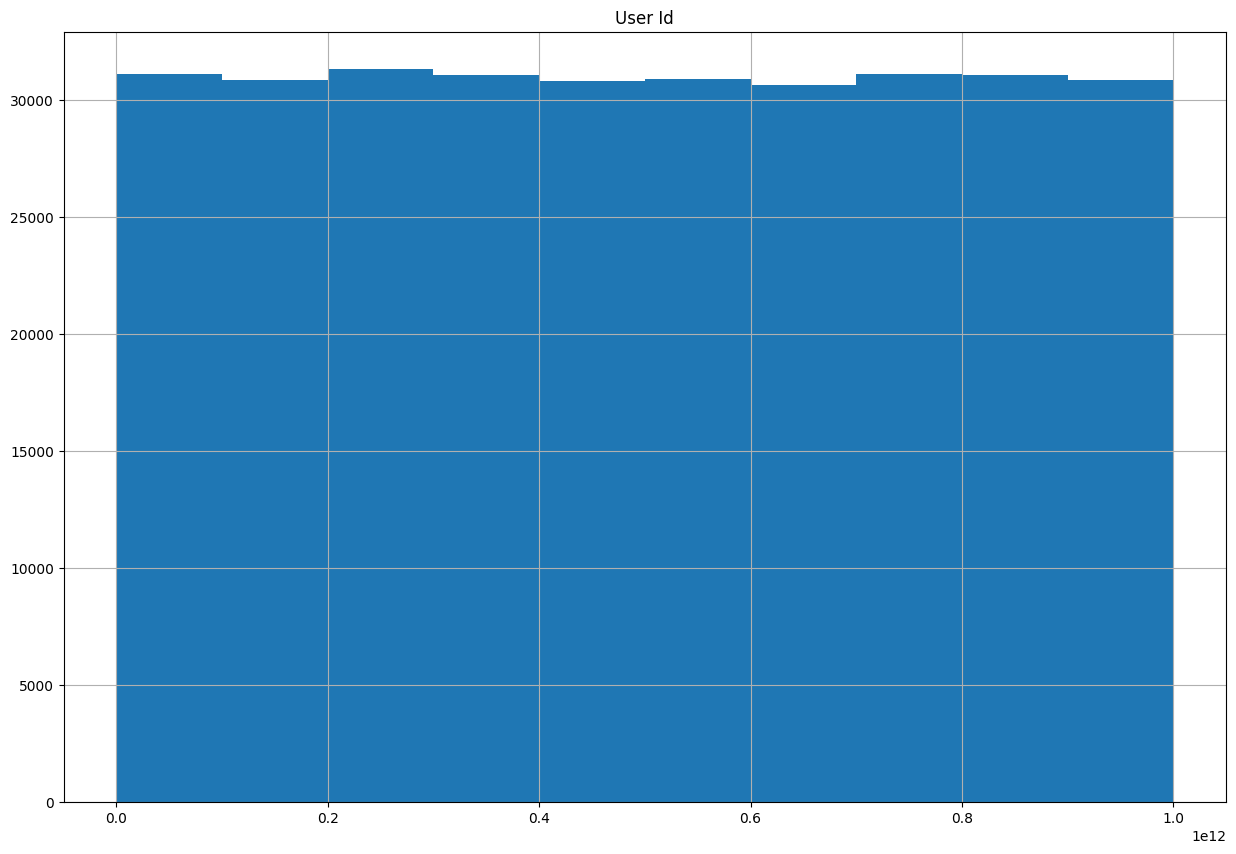

2024-05-01 19:26:46,642 - INFO - изменим название колонок:
2024-05-01 19:26:46,643 - INFO - ['User Id', 'Region', 'Device', 'Channel', 'Session Start', 'Session End']
2024-05-01 19:26:46,751 - INFO - пропусков не нашел
2024-05-01 19:26:47,333 - INFO - дубликатов не найдено
2024-05-01 19:26:47,636 - INFO - поменяли на временной формат колоку
2024-05-01 19:26:47,638 - INFO - session_start
2024-05-01 19:26:47,872 - INFO - поменяли на временной формат колоку
2024-05-01 19:26:47,873 - INFO - session_end
2024-05-01 19:26:47,873 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-01 19:26:47,876 - INFO - покупки


----------------------------------------------------------------------------------------------------


2024-05-01 19:26:48,865 - INFO - works online
2024-05-01 19:26:49,743 - INFO - read file sucsess
2024-05-01 19:26:49,745 - INFO - первое представление о данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

****************************************************************************************************


User Id       Revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000

****************************************************************************************************


None

****************************************************************************************************


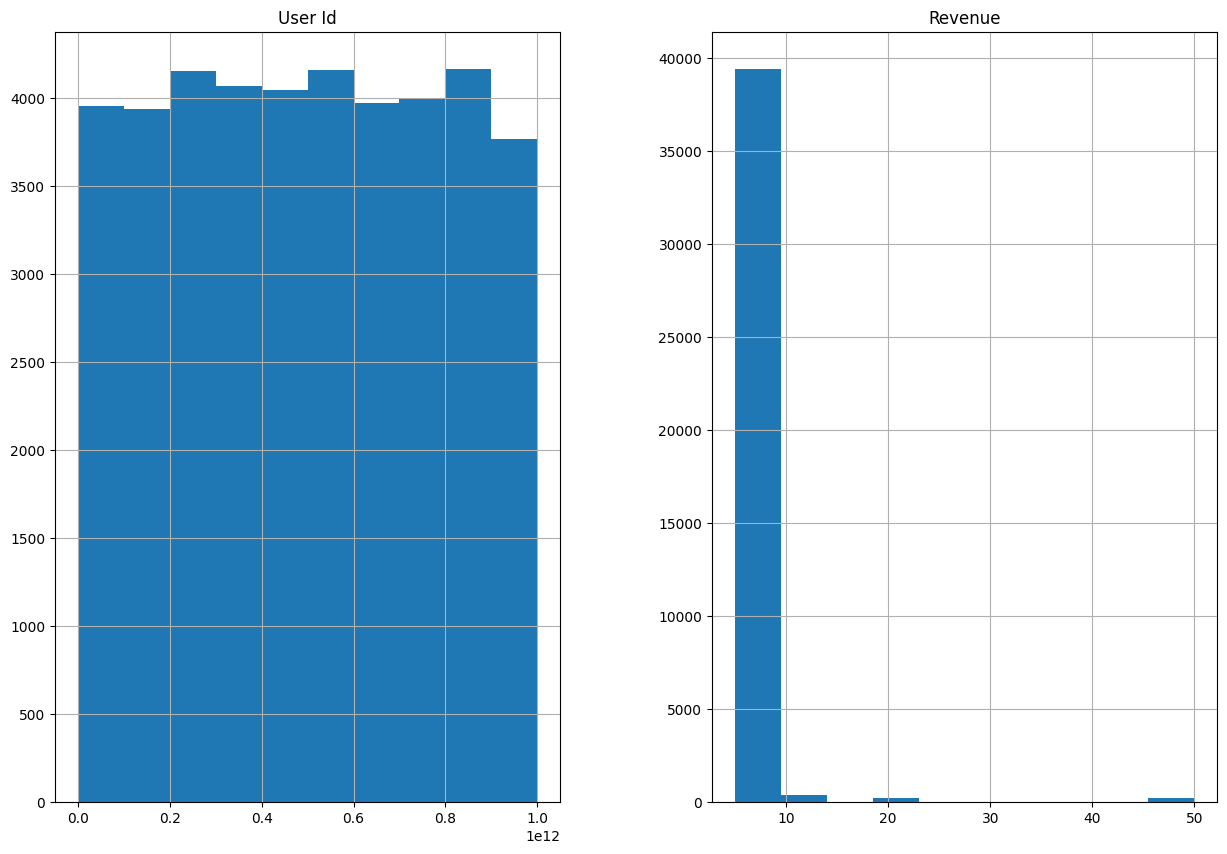

2024-05-01 19:26:50,253 - INFO - изменим название колонок:
2024-05-01 19:26:50,254 - INFO - ['User Id', 'Event Dt', 'Revenue']
2024-05-01 19:26:50,267 - INFO - пропусков не нашел
2024-05-01 19:26:50,306 - INFO - дубликатов не найдено
2024-05-01 19:26:50,350 - INFO - поменяли на временной формат колоку
2024-05-01 19:26:50,352 - INFO - event_dt
2024-05-01 19:26:50,353 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-01 19:26:50,356 - INFO - затраты на рекламу


----------------------------------------------------------------------------------------------------


2024-05-01 19:26:50,800 - INFO - works online
2024-05-01 19:26:51,229 - INFO - read file sucsess
2024-05-01 19:26:51,232 - INFO - первое представление о данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

****************************************************************************************************


costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000

****************************************************************************************************


None

****************************************************************************************************


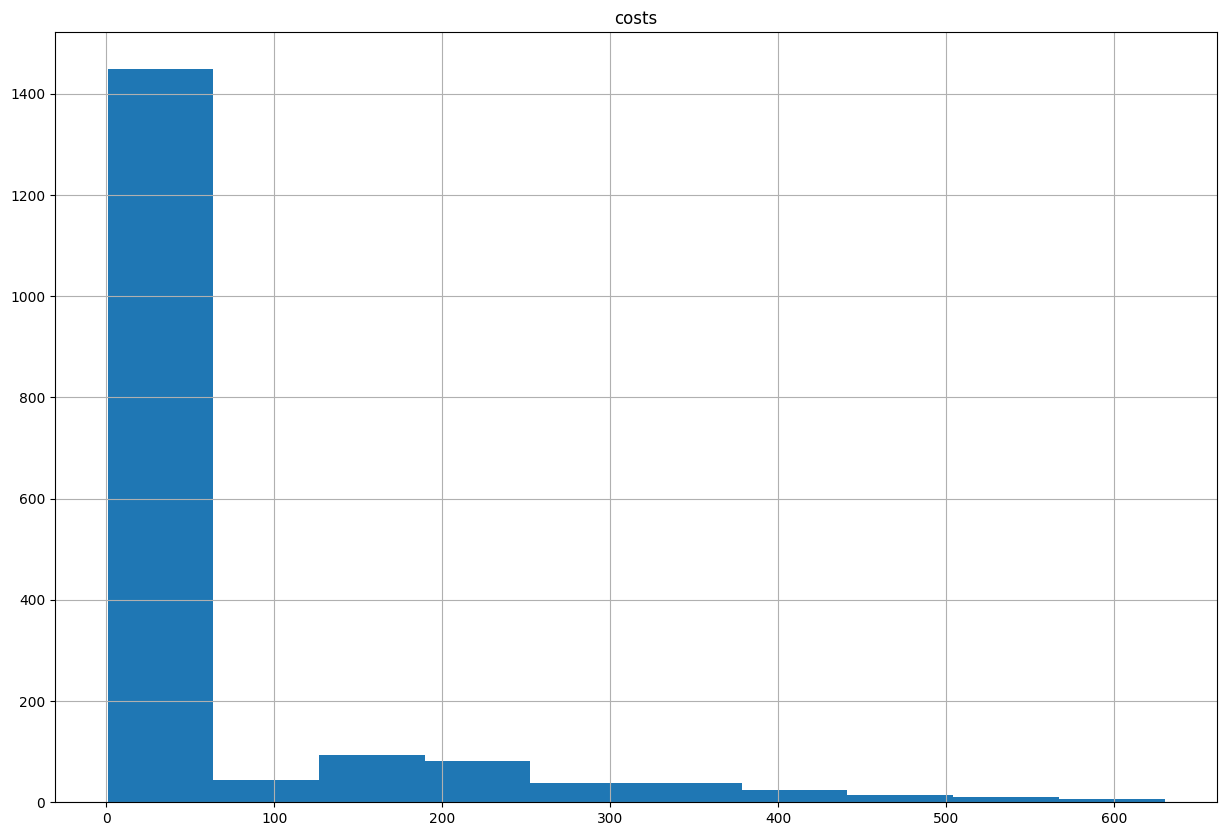

2024-05-01 19:26:51,568 - INFO - изменим название колонок:
2024-05-01 19:26:51,569 - INFO - ['Channel']
2024-05-01 19:26:51,572 - INFO - пропусков не нашел
2024-05-01 19:26:51,584 - INFO - дубликатов не найдено
2024-05-01 19:26:51,588 - INFO - поменяли на временной формат колоку
2024-05-01 19:26:51,590 - INFO - dt
2024-05-01 19:26:51,591 - INFO - выдыхай, бобер, первичная обработка данных окончена


In [4]:
# чтение и обработка данных
logging.info('визиты')
visits = process_data(os.getenv('aob_v', ''), 'visits_info_short.csv')
print('-'*100)

logging.info('покупки')
orders = process_data(os.getenv('aob_o', ''), 'orders_info_short.csv')
print('-'*100)

logging.info('затраты на рекламу')
costs = process_data(os.getenv('aob_c', ''), 'costs_info_short.csv')


In [5]:
costs['dt'] = costs['dt'].dt.date

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания пользовательских профилей

In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M').dt.to_timestamp()
    # profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчёта удержания

In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчёта конверсии

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчёта LTV и ROI

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

 Функция для сглаживания фрейма

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для визуализации удержания

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для визуализации конверсии

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [14]:
# Определим минимальную и максимальную даты привлечения пользователей.

profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))
print(f'минимальная дата привлечения пользователей {profiles["first_ts"].min()}, максимальная дата - {profiles["first_ts"].max()}')

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    faceboom     mac  united states   
1   4919697 2019-07-09 12:46:07    faceboom  iphone  united states   
2   6085896 2019-10-01 09:58:33     organic  iphone         france   
3  22593348 2019-08-22 21:35:48  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:44     yrabbit  iphone  united states   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

минимальная дата привлечения пользователей 2019-05-01 00:00:41, максимальная дата - 2019-10-27 23:59:04


минимальная дата привлечения пользователей 2019-05-01 00:00:41, максимальная дата - 2019-10-27 23:59:04

In [15]:
def make_anal(dim: str) -> tuple[pd.DataFrame]:
    """группирует по признаку, разделяет на платящих и не платящих"""
    table = profiles.groupby(by=dim).agg({'user_id':'nunique'}).reset_index()
    table_p = profiles.query('payer == True').groupby(by=dim).agg({'user_id':'nunique'}).reset_index()
    final = table.merge(table_p, on=dim).rename(columns={'user_id_x':'all_users', 'user_id_y': 'payers'})
    final['payers, %'] = round(final['payers']/final['all_users']*100, 2)
    final = final.sort_values(by='payers, %', ascending=False).reset_index().drop(columns='index')
    return table, table_p, final


In [16]:
# Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
# Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

table, table_p, final = make_anal('region')

print('Пользователи призодят из: ', *list(final['region']))
print(f'На {final["region"][0]} - приходится больше всего платящих пользователей.')
display(final)

Пользователи призодят из:  united states germany uk france
На united states - приходится больше всего платящих пользователей.


region  all_users  payers  payers, %
0  united states     100002    6902       6.90
1        germany      14981     616       4.11
2             uk      17575     700       3.98
3         france      17450     663       3.80

<p>Пользователи призодят из: united states, germany, uk, france.</p>
<p>На united states приходится больше всего платящих пользователей.</p>

In [17]:
# Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
# Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

table, table_p, final = make_anal('device')

print('Пользователи пользуются устройствами ', *list(final['device']))
print(*table_p.sort_values(by='user_id', ascending=False)['device'].to_list()[:2],' предпочитают платящие пользователи')


display(final)


Пользователи пользуются устройствами  mac iphone android pc
iphone android  предпочитают платящие пользователи


device  all_users  payers  payers, %
0      mac      30042    1912       6.36
1   iphone      54479    3382       6.21
2  android      35032    2050       5.85
3       pc      30455    1537       5.05

<p>Пользователи пользуются устройствами: mac, iphone, android, pc</p>
<p>iphone, android - предпочитают платящие пользователи.</p>

region   device  user_id
0          france  android     5252
1          france   iphone     3420
2          france      mac     1838
3          france       pc     6940
4         germany  android     4440
5         germany   iphone     3012
6         germany      mac     1584
7         germany       pc     5945
8              uk  android     5141
9              uk   iphone     3518
10             uk      mac     1778
11             uk       pc     7138
12  united states  android    20199
13  united states   iphone    44529
14  united states      mac    24842
15  united states       pc    10432

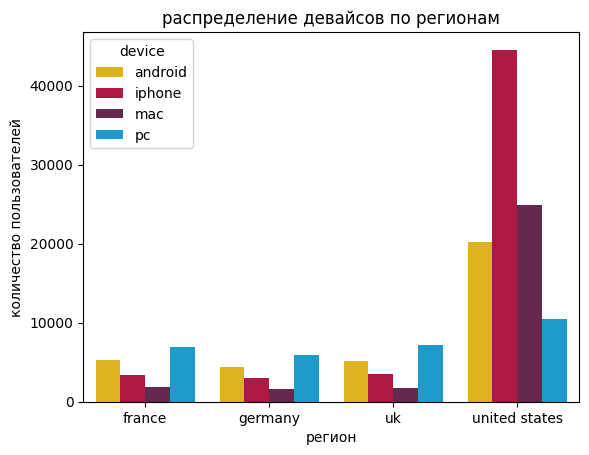

In [18]:
# Логично было бы предположить, что пользуются "яблочными" устройствами в Америке, но так-ли это?

result = profiles.groupby(by=['region', 'device']).agg({'user_id': 'nunique'}).reset_index()
display(result)

colors = ['#FFC300', '#C70039', '#6F1E51', '#00A8E8'] 
sns.barplot(x='region', y='user_id', hue='device', data=result, palette=colors)
plt.title('распределение девайсов по регионам')
plt.xlabel('регион')
plt.ylabel('количество пользователей')
plt.show();


<p>получается, что так 😊</p>
<p>на данной выборке из покупателей гипотеза подтвердилась</p>

каналы, из которых пришло больше всего платящих пользователей  faceboom tiptop organic wahoonetbanner adnonsense


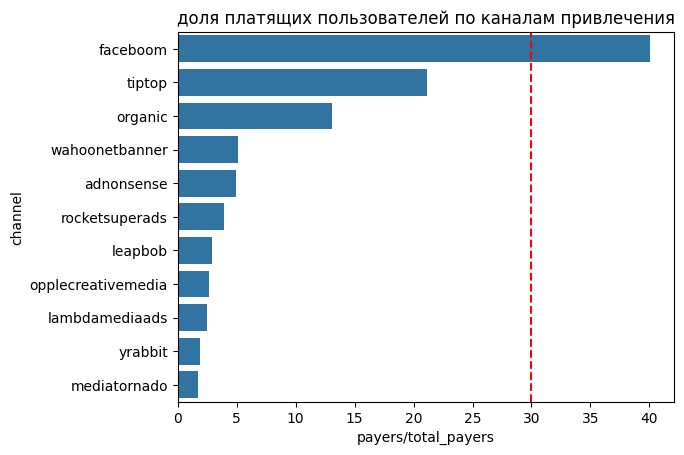

channel  all_users  payers  payers, %  payers/total_payers
0             faceboom      29144    3557      12.20                40.05
1           adnonsense       3880     440      11.34                 4.95
2       lambdamediaads       2149     225      10.47                 2.53
3               tiptop      19561    1878       9.60                21.15
4       rocketsuperads       4448     352       7.91                 3.96
5       wahoonetbanner       8553     453       5.30                 5.10
6              yrabbit       4312     165       3.83                 1.86
7         mediatornado       4364     156       3.57                 1.76
8              leapbob       8553     262       3.06                 2.95
9   opplecreativemedia       8605     233       2.71                 2.62
10             organic      56439    1160       2.06                13.06

In [19]:
# Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.
# Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

table, table_p, final = make_anal('channel')

print('каналы, из которых пришло больше всего платящих пользователей ',
      *final.sort_values(by='payers', ascending=False)['channel'].to_list()[:5])

final['payers/total_payers'] = round((final['payers']/final['payers'].sum())*100, 2)
sns.barplot(x='payers/total_payers', y='channel', data=final.sort_values(by='payers/total_payers', ascending=False))
plt.axvline(x=30, color='red', linestyle='--', label='Вертикальная линия')
plt.title('доля платящих пользователей по каналам привлечения')
plt.show();

display(final)


<p>каналы, из которых пришло больше всего платящих пользователей  faceboom tiptop organic wahoonetbanner adnonsense</p>

In [20]:
# Какую долю всех пользователей занимает органика

print(round(float(final.query('channel == "organic"')['all_users']/final['all_users'].sum())*100, 2),
      '% всех пользователей занимает органика')

37.62 % всех пользователей занимает органика


### Маркетинг

- Посчитайем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнайем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [21]:
# Посчитайте общую сумму расходов на маркетинг.
total_costs = round(costs['costs'].sum(), 1)
print(f'oбщая сумма расходов на маркетинг {total_costs}')

oбщая сумма расходов на маркетинг 105497.3


Основная часть расходов идет на два канала:  tiptop faceboom


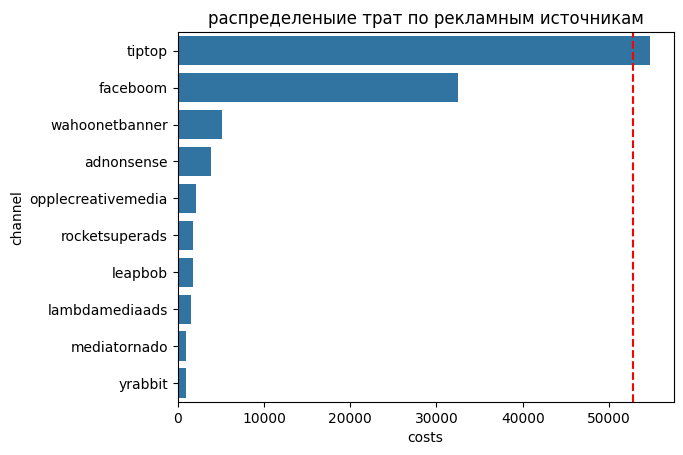

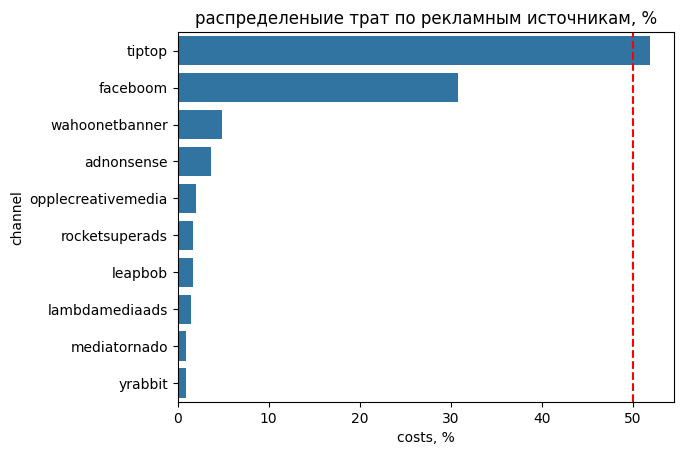

channel     costs  costs, %
7              tiptop  54751.30     51.90
1            faceboom  32445.60     30.75
8      wahoonetbanner   5151.00      4.88
0          adnonsense   3911.25      3.71
5  opplecreativemedia   2151.25      2.04
6      rocketsuperads   1833.00      1.74
3             leapbob   1797.60      1.70
2      lambdamediaads   1557.60      1.48
4        mediatornado    954.48      0.90
9             yrabbit    944.22      0.90

In [22]:
# Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

result = (costs
          .groupby(by='channel')
          .agg({'costs': 'sum'})
          .reset_index()
          .sort_values(by='costs', ascending=False)
         )

print('Основная часть расходов идет на два канала: ', *result["channel"].to_list()[:2])

sns.barplot(x='costs', y='channel', data=result)
plt.title('распределеныие трат по рекламным источникам')
plt.axvline(x=costs['costs'].sum()/2, color='red', linestyle='--', label='Вертикальная линия')
plt.show();

result['costs, %'] = round((result['costs']/total_costs)*100, 2)
sns.barplot(x='costs, %', y='channel', data=result)
plt.title('распределеныие трат по рекламным источникам, %')
plt.axvline(x=50, color='red', linestyle='--', label='Вертикальная линия')
plt.show();

display(result)


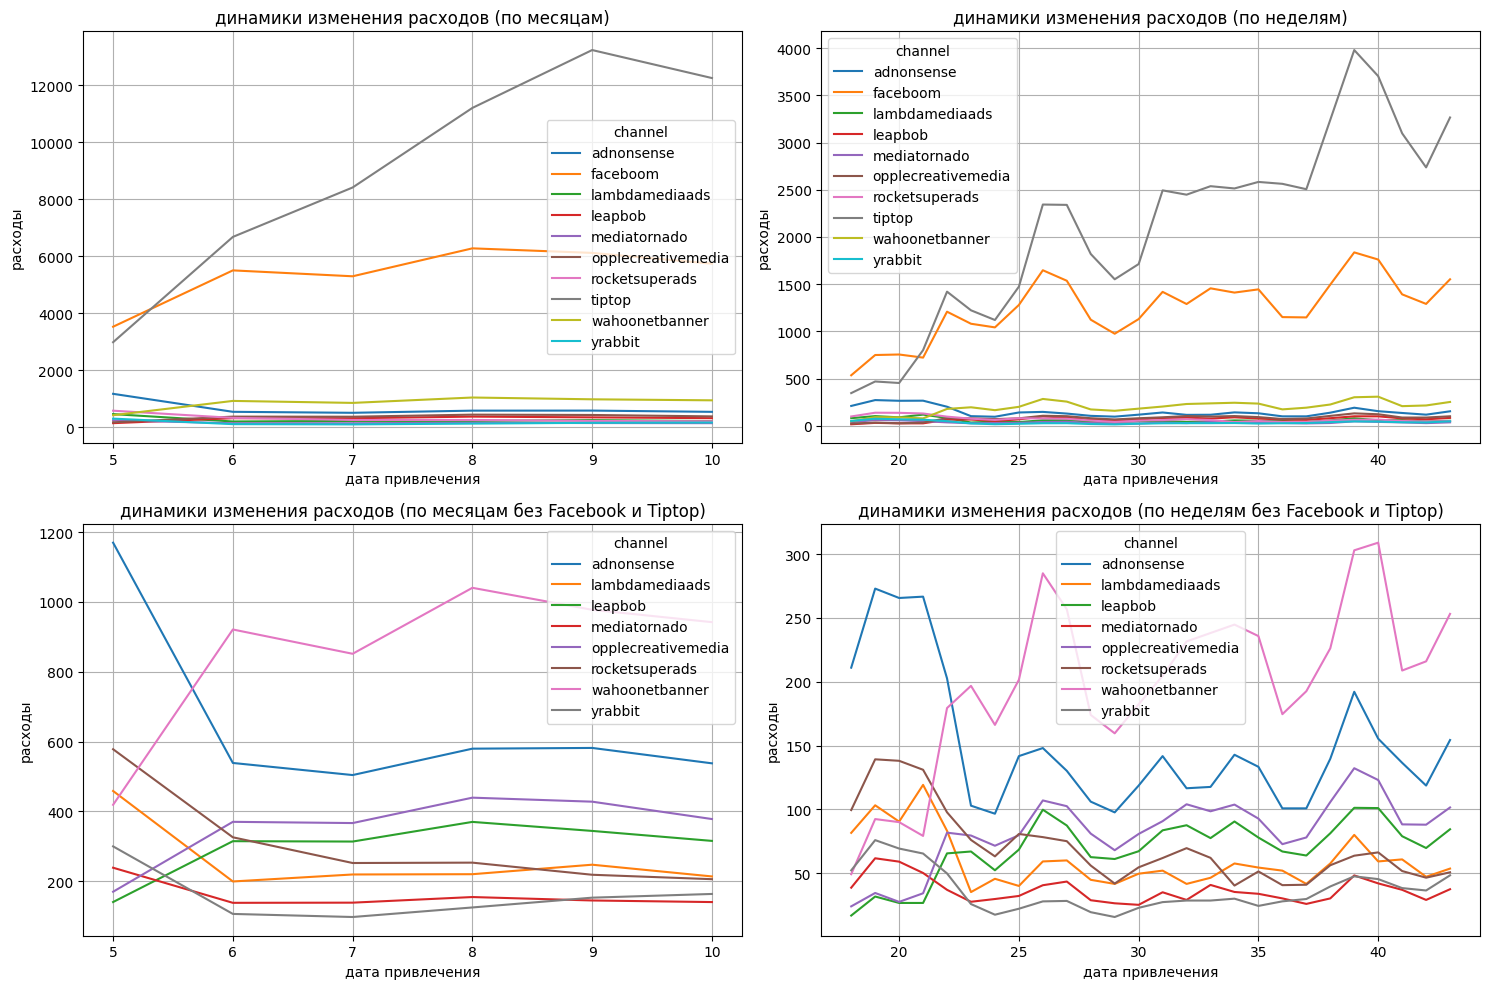

In [23]:
# Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
# Постарайтесь отразить это на одном графике.

costs['month'] = pd.to_datetime(costs['dt']).dt.month 
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week 
 
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
 
costs.pivot_table(  
    index='month', columns='channel', values='costs', aggfunc='sum'  
).plot(grid=True, ax=axs[0,0]) 
axs[0,0].set_ylabel('расходы')  
axs[0,0].set_xlabel('дата привлечения')  
axs[0,0].set_title('динамики изменения расходов (по месяцам)')  
 
costs.pivot_table(  
    index='week', columns='channel', values='costs', aggfunc='sum'  
).plot(grid=True, ax=axs[0,1]) 
axs[0,1].set_ylabel('расходы')  
axs[0,1].set_xlabel('дата привлечения')  
axs[0,1].set_title('динамики изменения расходов (по неделям)')  
 
costs.query('channel != "faceboom" and channel != "tiptop"').pivot_table(  
    index='month', columns='channel', values='costs', aggfunc='sum'  
).plot(grid=True, ax=axs[1,0]) 
axs[1,0].set_ylabel('расходы')  
axs[1,0].set_xlabel('дата привлечения')  
axs[1,0].set_title('динамики изменения расходов (по месяцам без Facebook и Tiptop)')  
 
costs.query('channel != "faceboom" and channel != "tiptop"').pivot_table(  
    index='week', columns='channel', values='costs', aggfunc='sum'  
).plot(grid=True, ax=axs[1,1]) 
axs[1,1].set_ylabel('расходы')  
axs[1,1].set_xlabel('дата привлечения')  
axs[1,1].set_title('динамики изменения расходов (по неделям без Facebook и Tiptop)') 
 
plt.tight_layout() 
plt.show();

channel  acquisition_cost  is_top      diff
0              tiptop          2.799003    True  1.671522
1            faceboom          1.113286   False -0.014196
2          adnonsense          1.008054   False -0.119427
3      lambdamediaads          0.724802   False -0.402679
4      wahoonetbanner          0.602245   False -0.525236
5      rocketsuperads          0.412095   False -0.715386
6  opplecreativemedia          0.250000   False -0.877481
7             yrabbit          0.218975   False -0.908506
8        mediatornado          0.218717   False -0.908765
9             leapbob          0.210172   False -0.917309

В среднем наиболее дорого привлекать пользователя на платформах:  tiptop faceboom


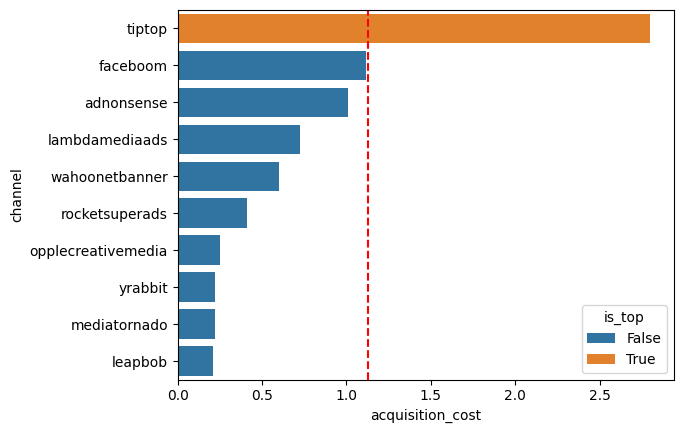

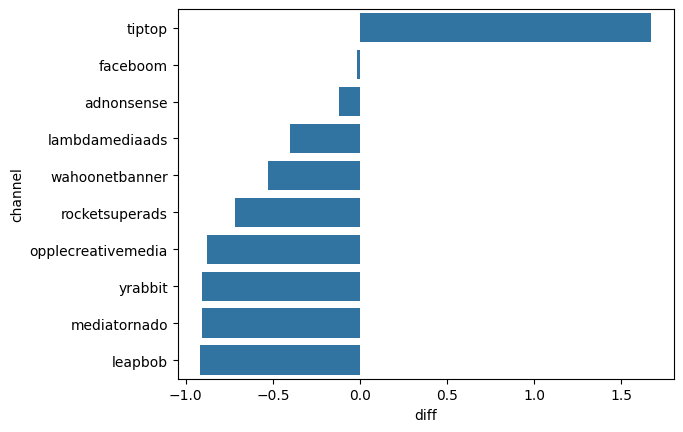

tiptop - платформы, у которых CAC выше среднего


In [24]:
# Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.
# Используйте профили пользователей.

result = (
     profiles.query('channel != "organic"')
            .groupby('channel')
            .agg({'acquisition_cost':'mean'})
            .sort_values(by='acquisition_cost',
                         ascending = False)
            .reset_index()
)

mean = profiles.query('channel != "organic"')['acquisition_cost'].mean()

def is_top(row):
    if row['acquisition_cost'] >= mean:
        return True
    return False

result['is_top'] = result.apply(is_top, axis=1)

result['diff'] = result['acquisition_cost'] - mean

display(result)
print('В среднем наиболее дорого привлекать пользователя на платформах: ', *result['channel'].to_list()[:2])

sns.barplot(x='acquisition_cost', y='channel', data=result, hue='is_top')
plt.axvline(x=mean, color='red', linestyle='--', label='Уровень окупаемости')
plt.show();

sns.barplot(x='diff', y='channel', data=result)
plt.show();
liders_cac = result['channel'].head(4).to_list()
print(*result.query('is_top == True')['channel'].to_list(), '- платформы, у которых CAC выше среднего')

<p><b><i>Промежуточный вывод</i></b></p>
<ol>
    <li>Общая сумма расходов на маркетинг 105497.3</li>
    <li>Основная часть расходов идет на два канала: tiptop, faceboom</li>
    <li>В среднем наиболее дорого привлекать пользователя на платформах: tiptop, faceboom</li>
    <li>tiptop - платформа, у которых CAC выше средне</li>
</ol>

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [25]:
profiles = profiles.query('channel != "organic"') 

In [26]:
observation_date = datetime(2019, 11, 1)
horizon_days  = 14

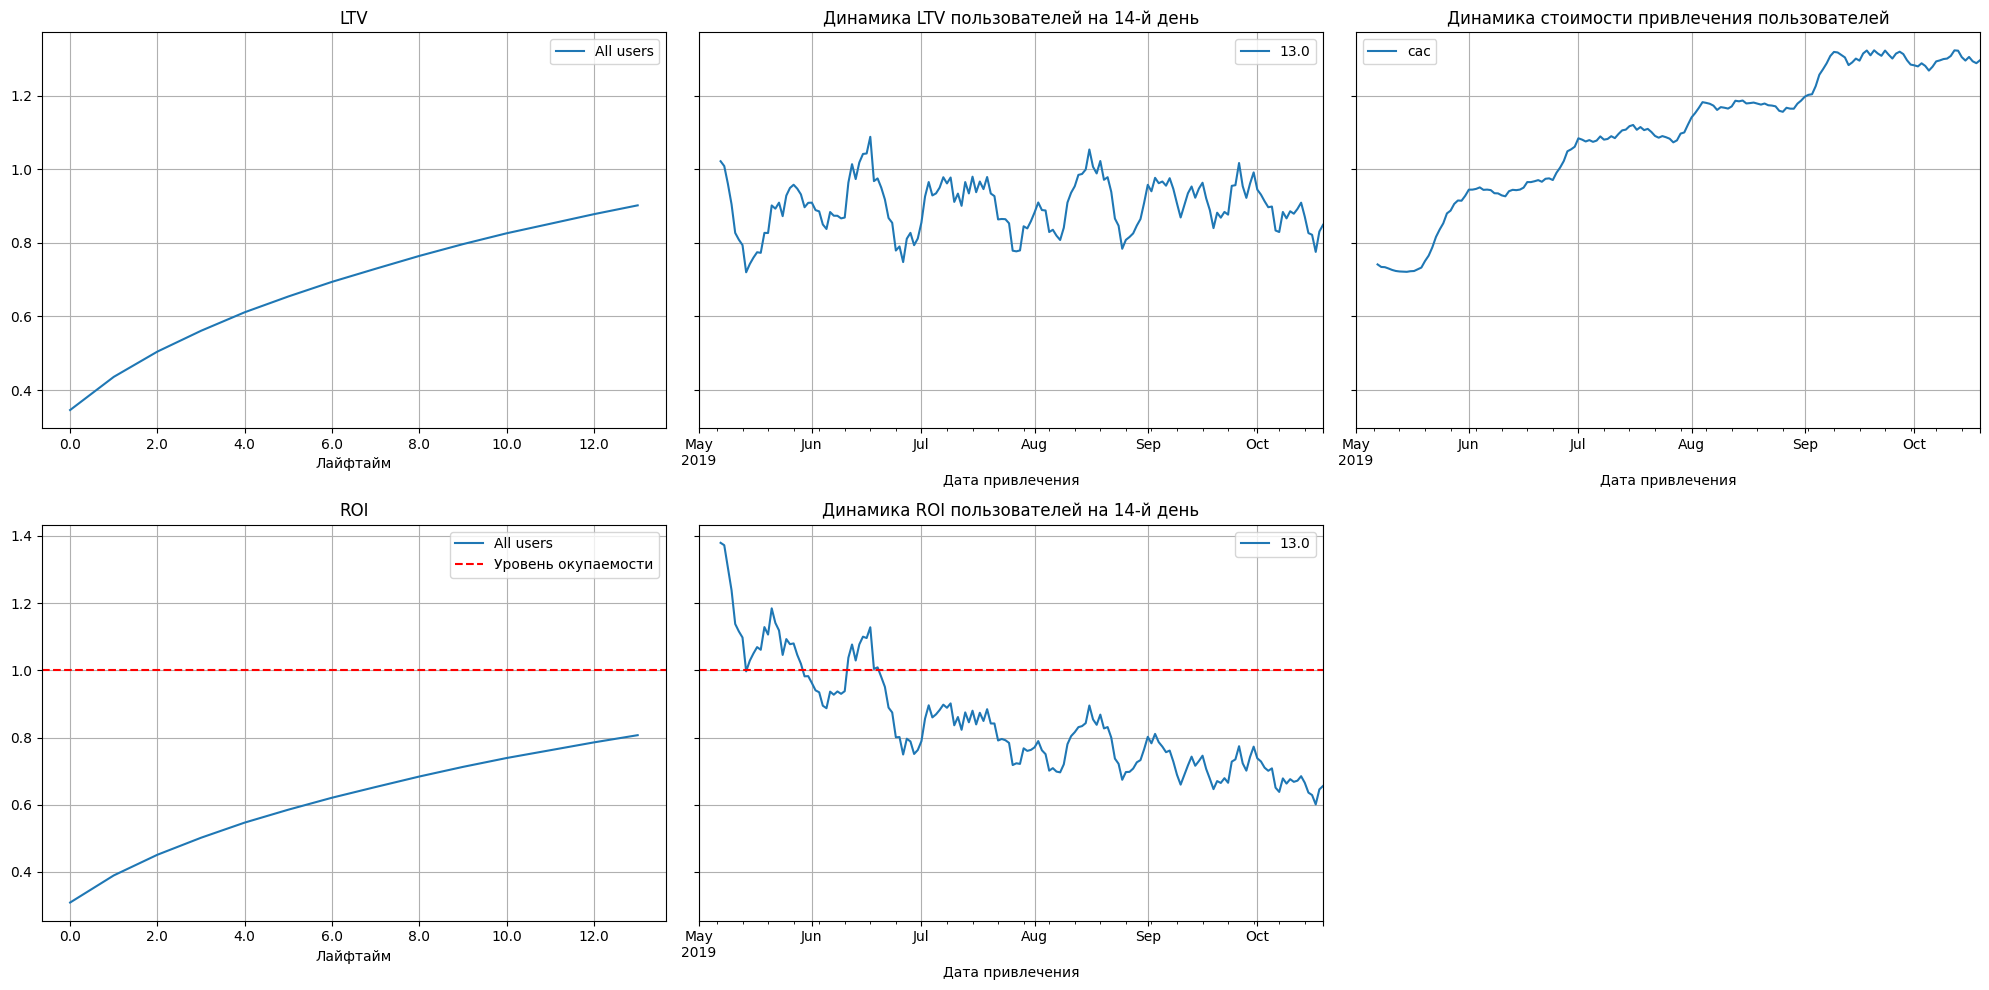

In [27]:
# считаем LTV и ROI
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<p>По графикам можно сделать такие выводы:</p>
<ul>
    <li>Реклама не окупается в принципе к коцнцу второй неделе. Интересно, что реклама перестала окупаться после августа.</li>
    <li>CAC увеличивается с каждым месяцем. Возможно, что проблема с окупаемостью летом вызвана резким ростом бюджета</li>
    <li>На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.</li>
</ul>

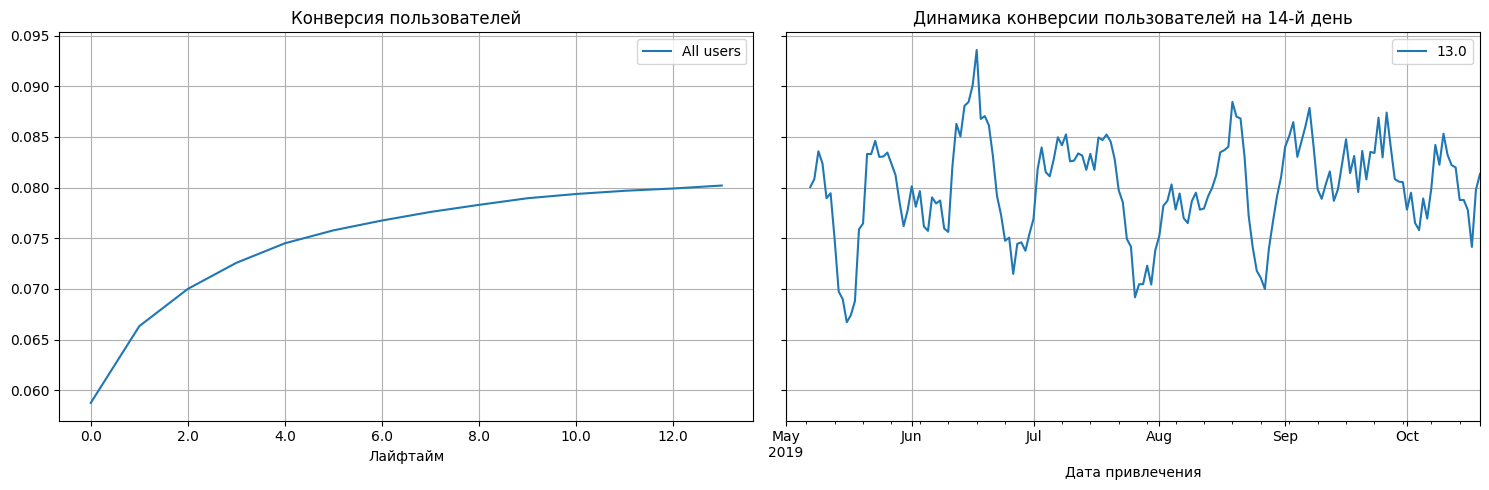

In [28]:
# Проверьте конверсию пользователей и динамику её изменения.
# Постройте и изучите графики конверсии.

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи конвертируются достаточно хорошо. Конверсия на 14 день подтвержена сезонным факторам, но в принципе стабильна.

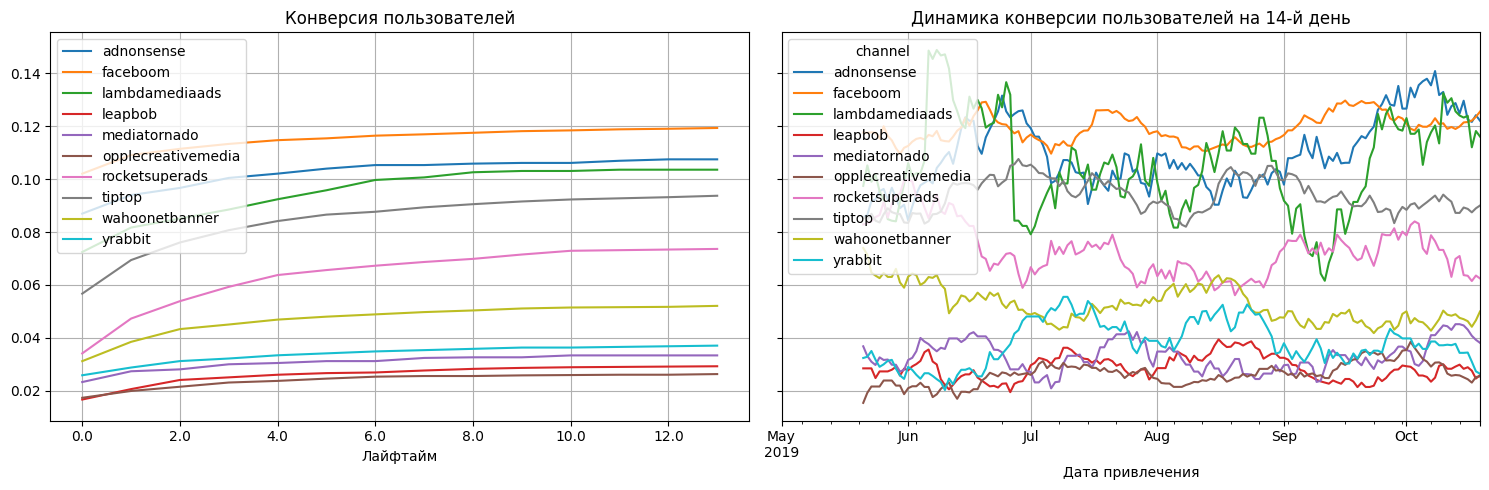

In [29]:
dims = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=21)

Лучше всего конвертируются пользователи привлеченные из faceboom, а хуже всего leapbob, opplecreativemedia

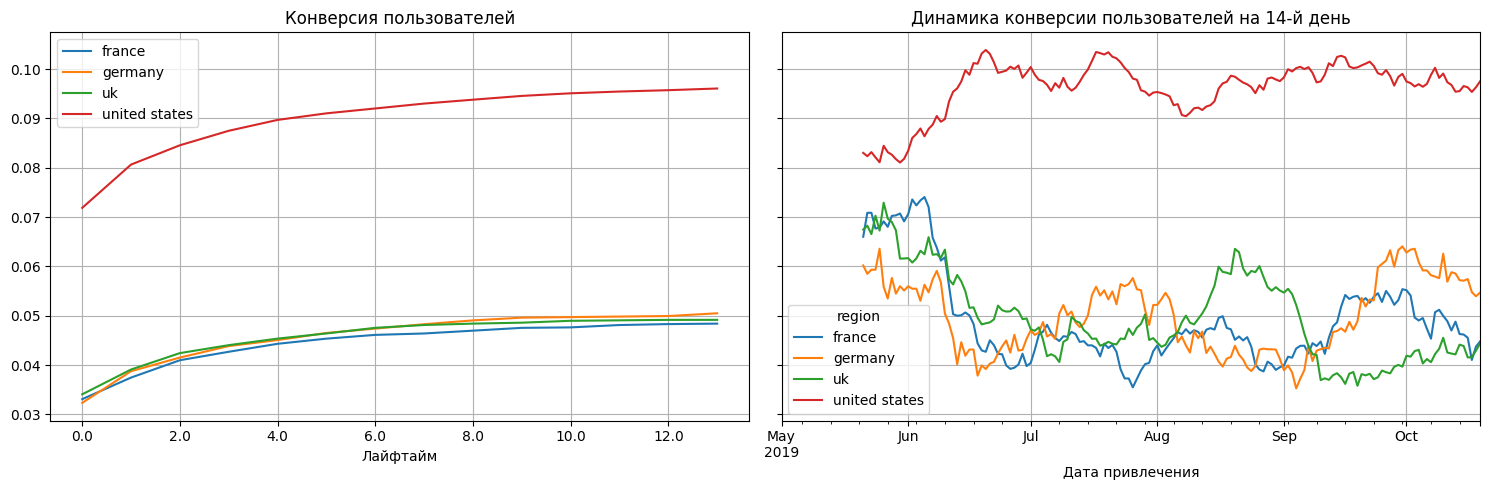

In [30]:
dims = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=21)

Самая большая коверсия идет из США

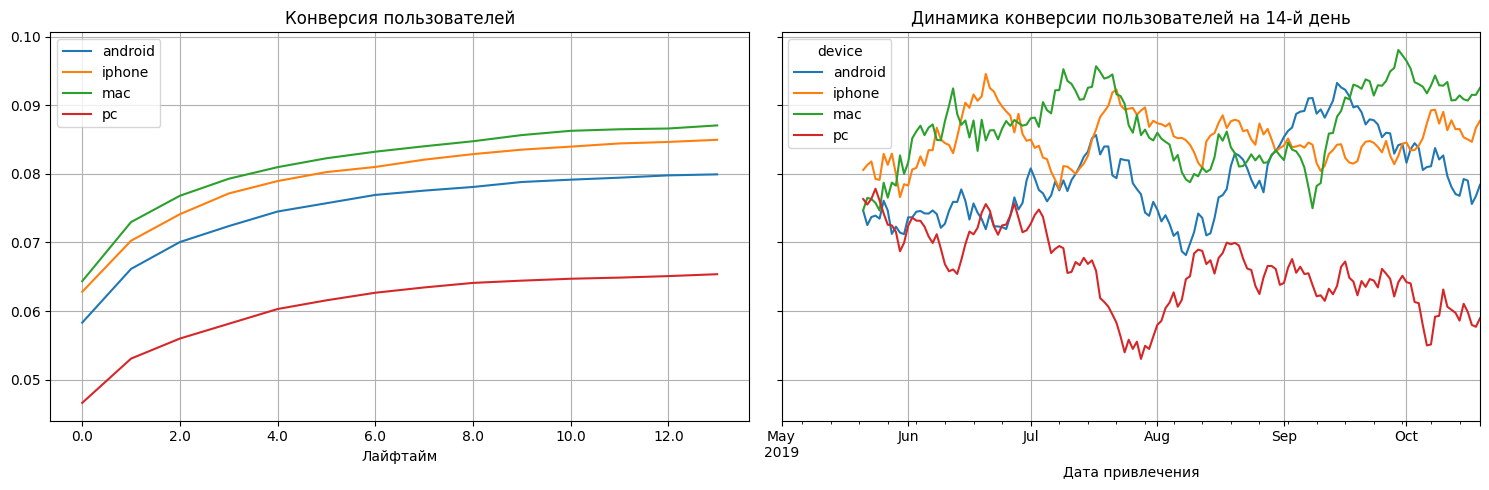

In [31]:
dims = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=21)

Пользователи pk - плохо конвертируются, по сравнению со всеми остальными, а лучше всего пользователи яблока. Получается, что американцы со своей яблочными девайсами лидируют.

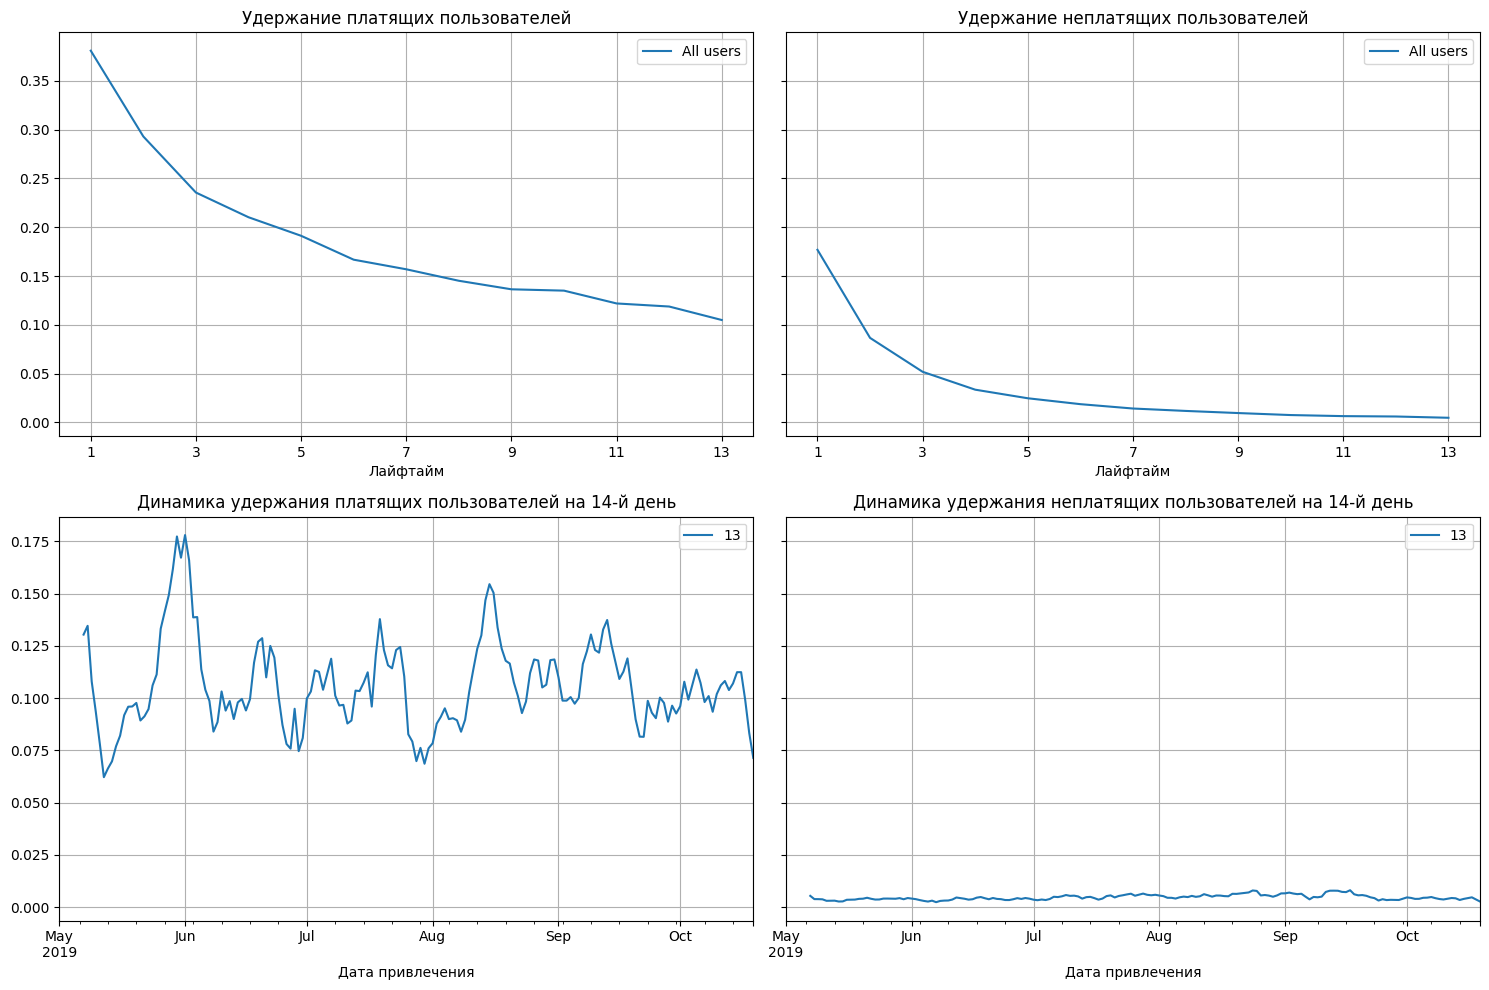

In [32]:
# То же самое сделайте с удержанием пользователей.
# Постройте и изучите графики удержания.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей идет в рабочем режиме, стоит отметить, что неплатящие пользователи почти полностью отваливаются к концу второй неделе. Стоит отметить, что у платящих удержание довольно быстро снижается и сам этот показатель на не очень высоком уровне

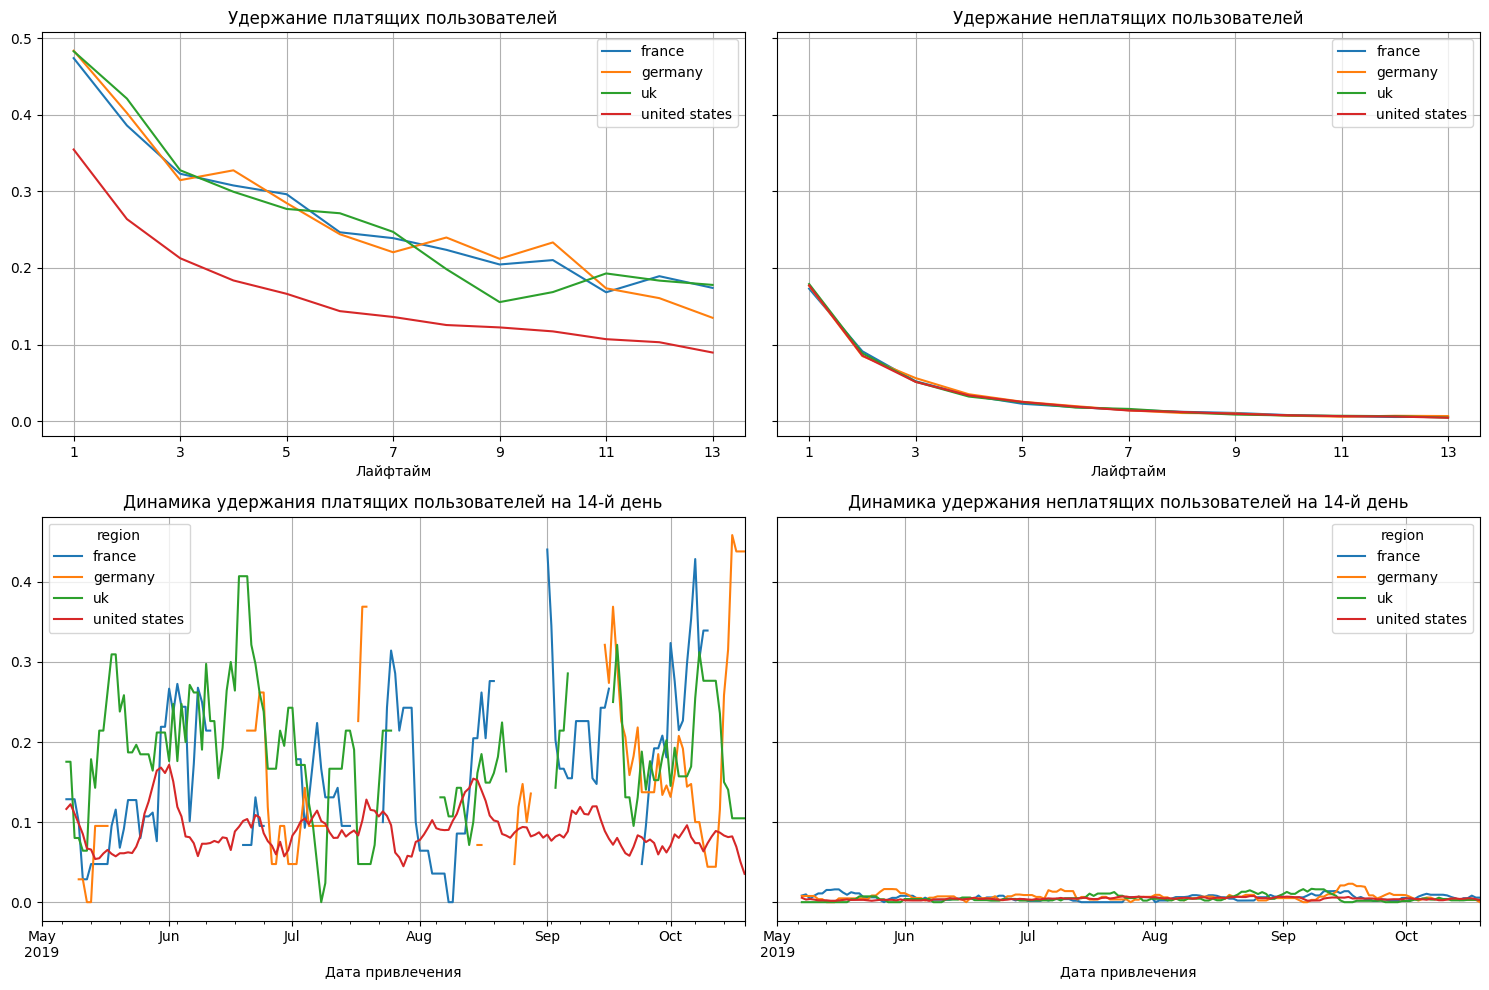

In [33]:
dims = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dims
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Стоит также обратить внимание на то, что пользователи из США удерживаются хуже всего - а между прочим, оттуда большинство платящих пользователей

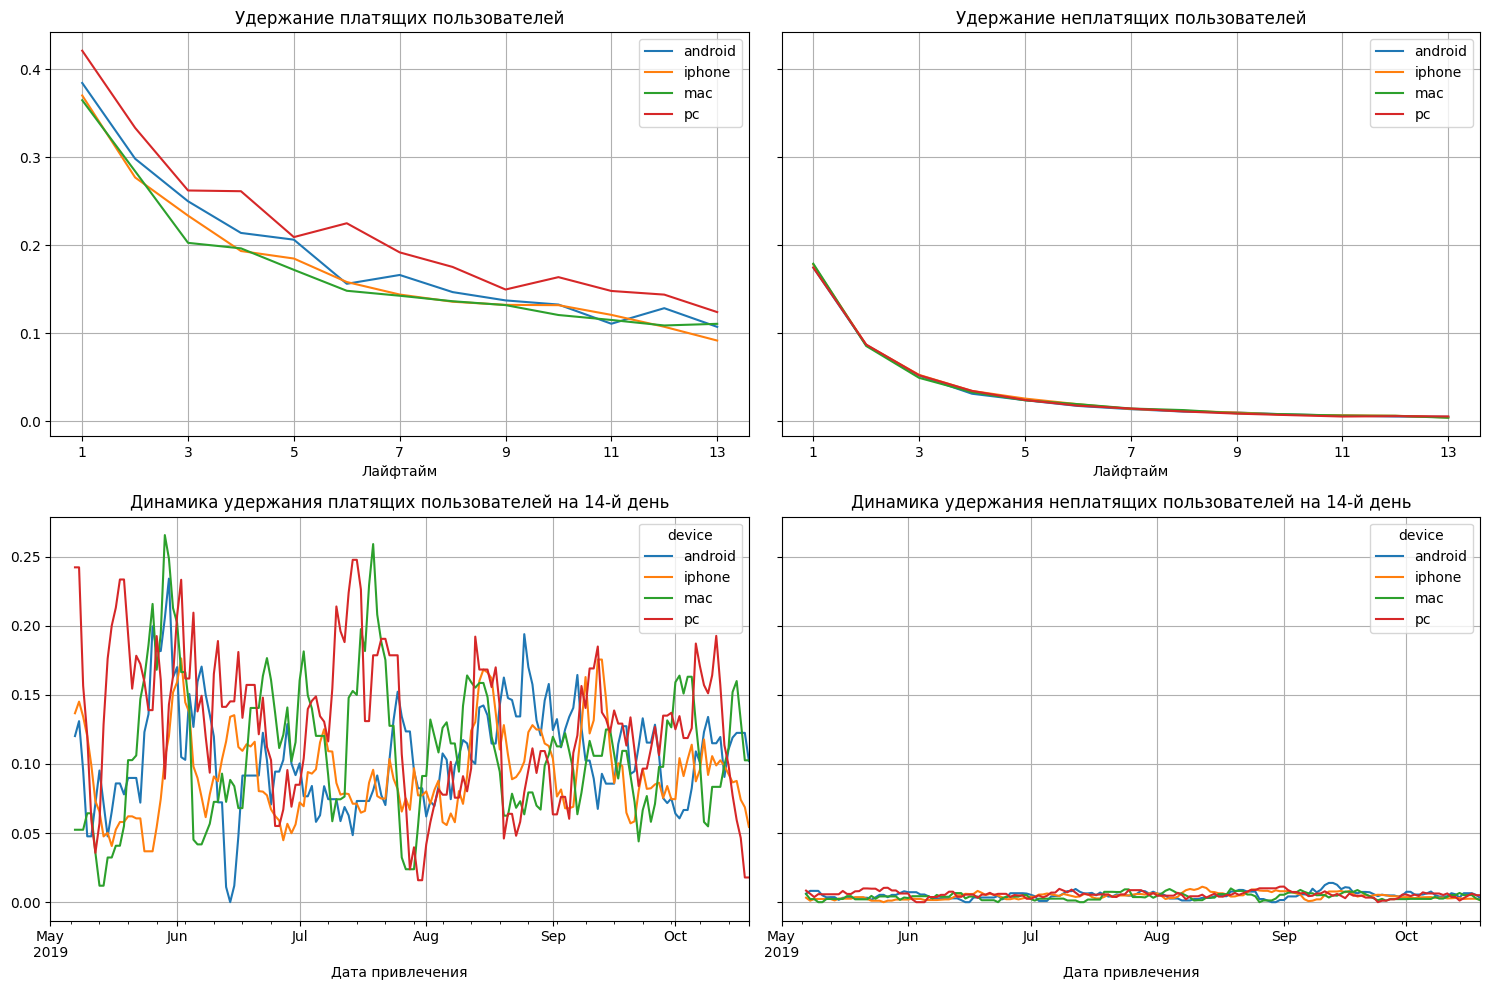

In [34]:
dims = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dims
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей слабо зависит от типа используемого средства

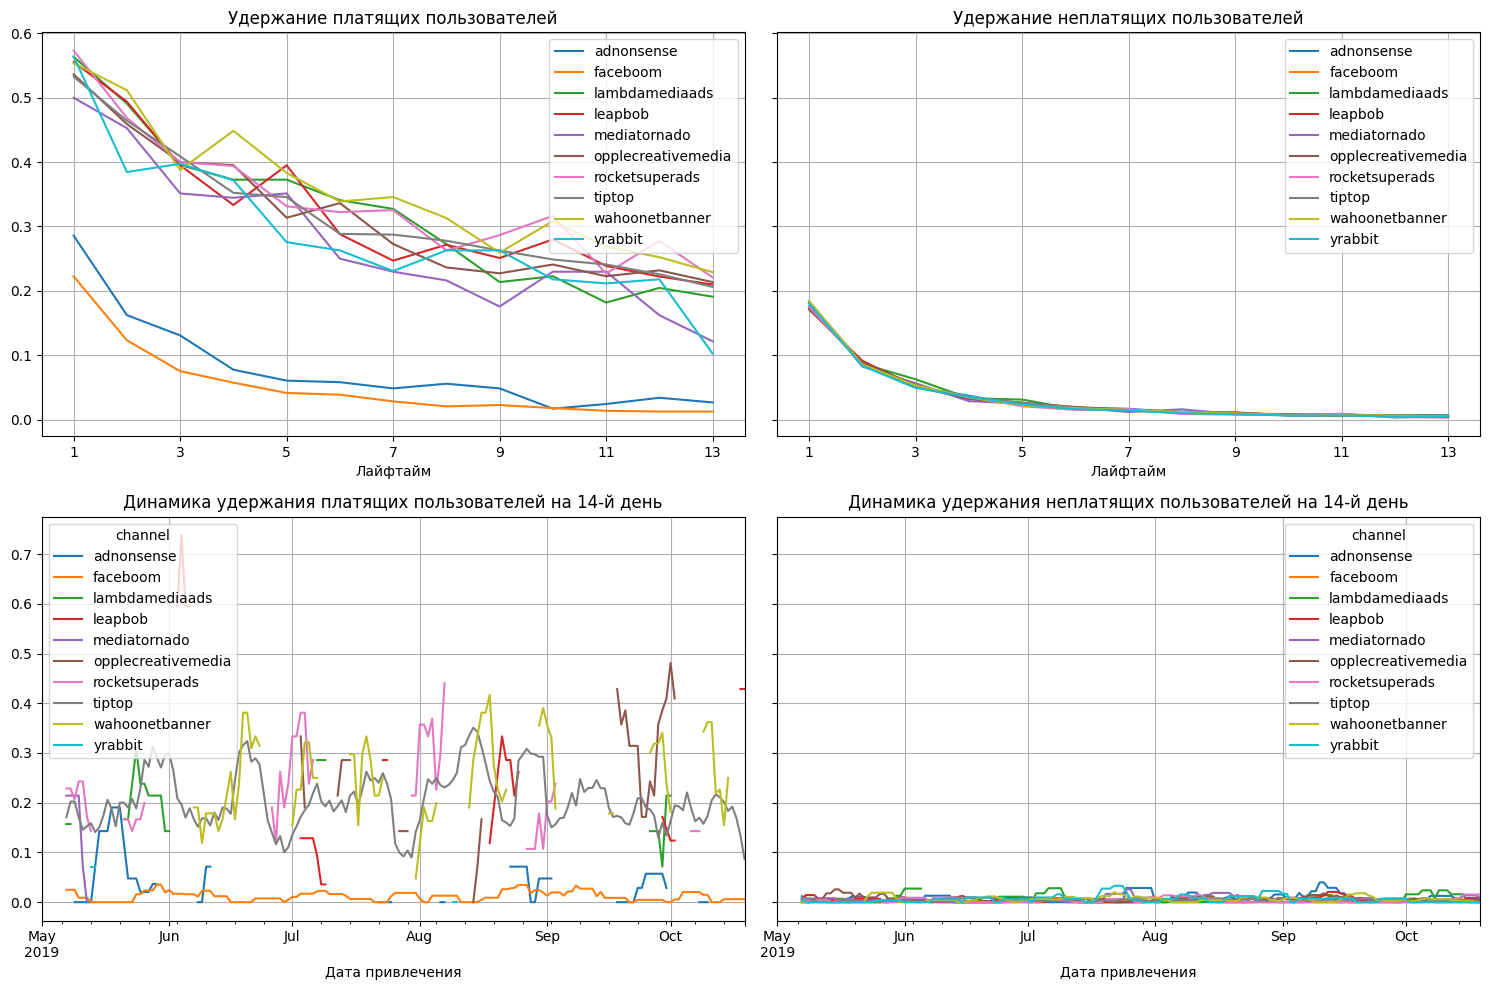

In [35]:
dims = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dims
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Интересно заметить, что плохо удерживаются пользователи, привлеченные из faceboom и adnonsense - а это одини из самых дорогих каналов привлечения

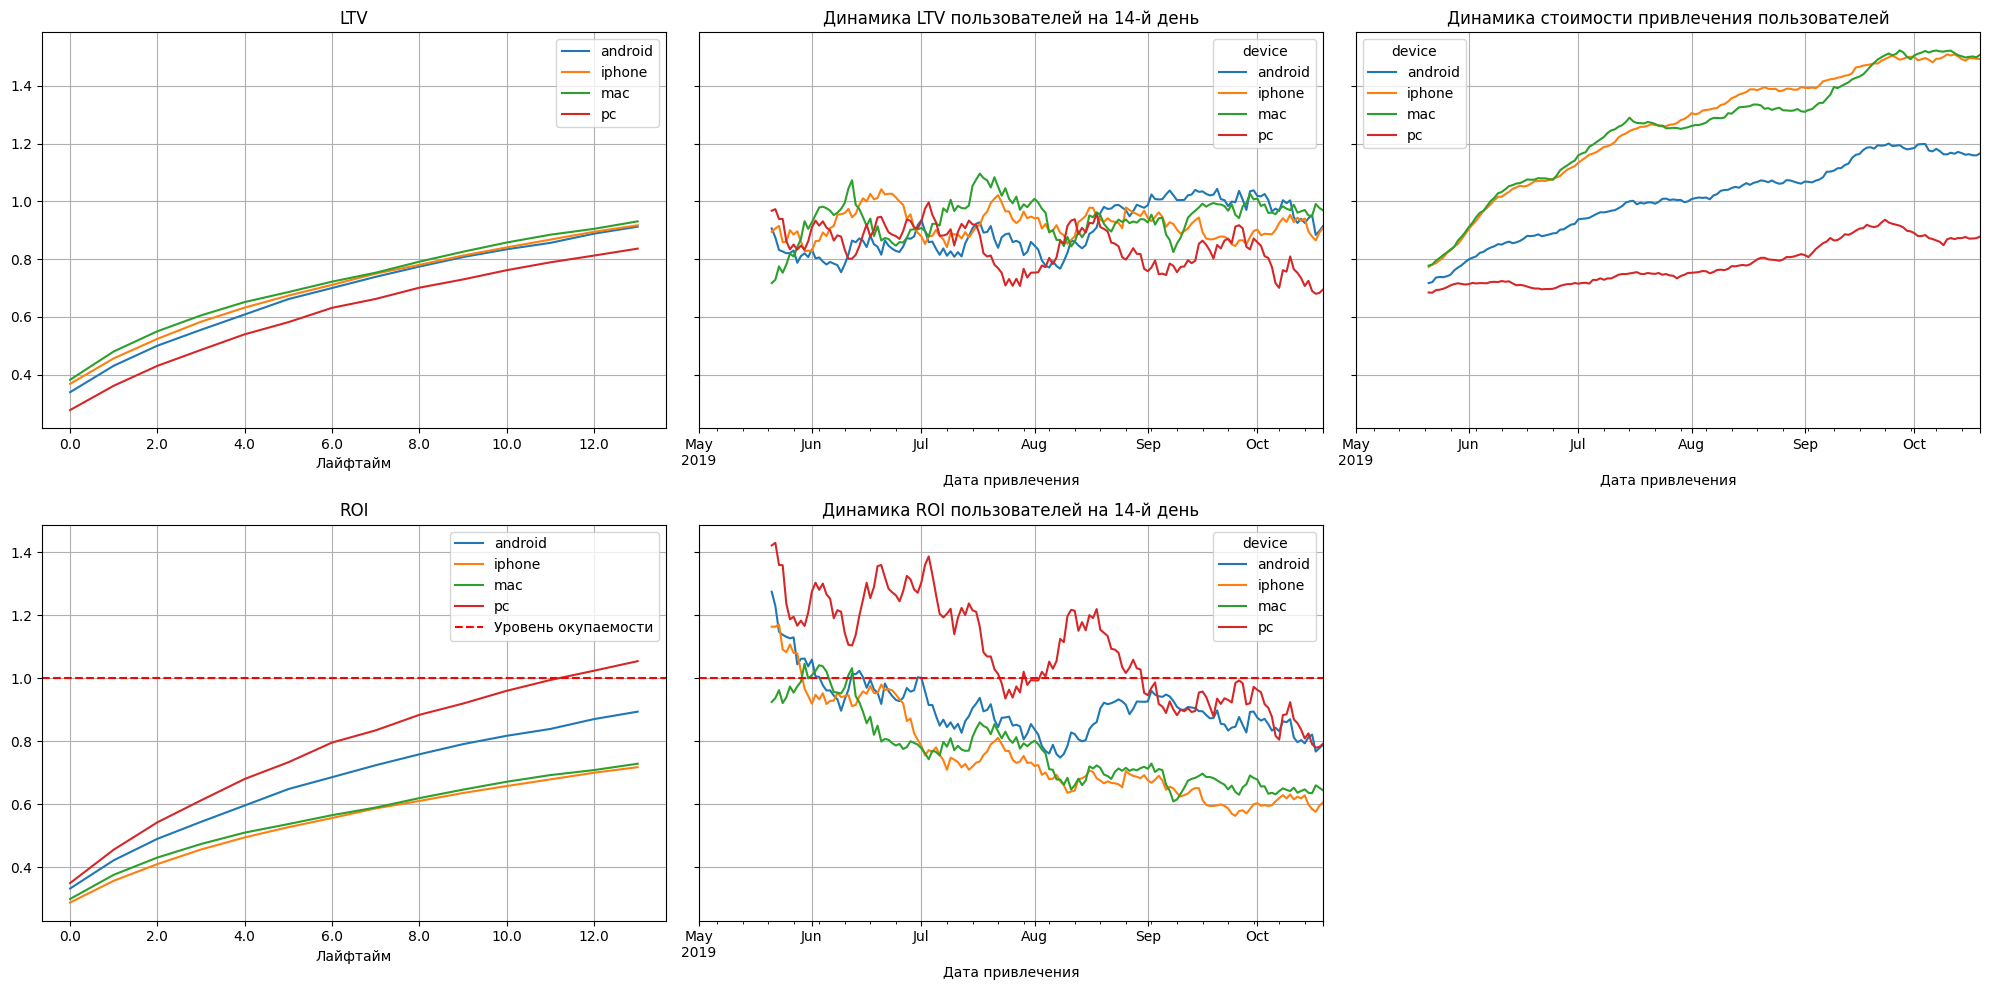

In [36]:
# Проанализируйте окупаемость рекламы с разбивкой по устройствам.
# Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dims = ['device']
# считаем LTV и ROI
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

<p>Из графикоф можно предположить, что не окупаются пользователи продукции apple - стоимость их привлечения растет быстрее чем выручка от них.</p>
<p>Динамика LTV на 14 день достаточно стабильна, хотя и подтвержена некоторым колебаниям</p>
<p>Интересно отметить, что при самом низком LTV - окупаются исключительно пользователи pk/</p>

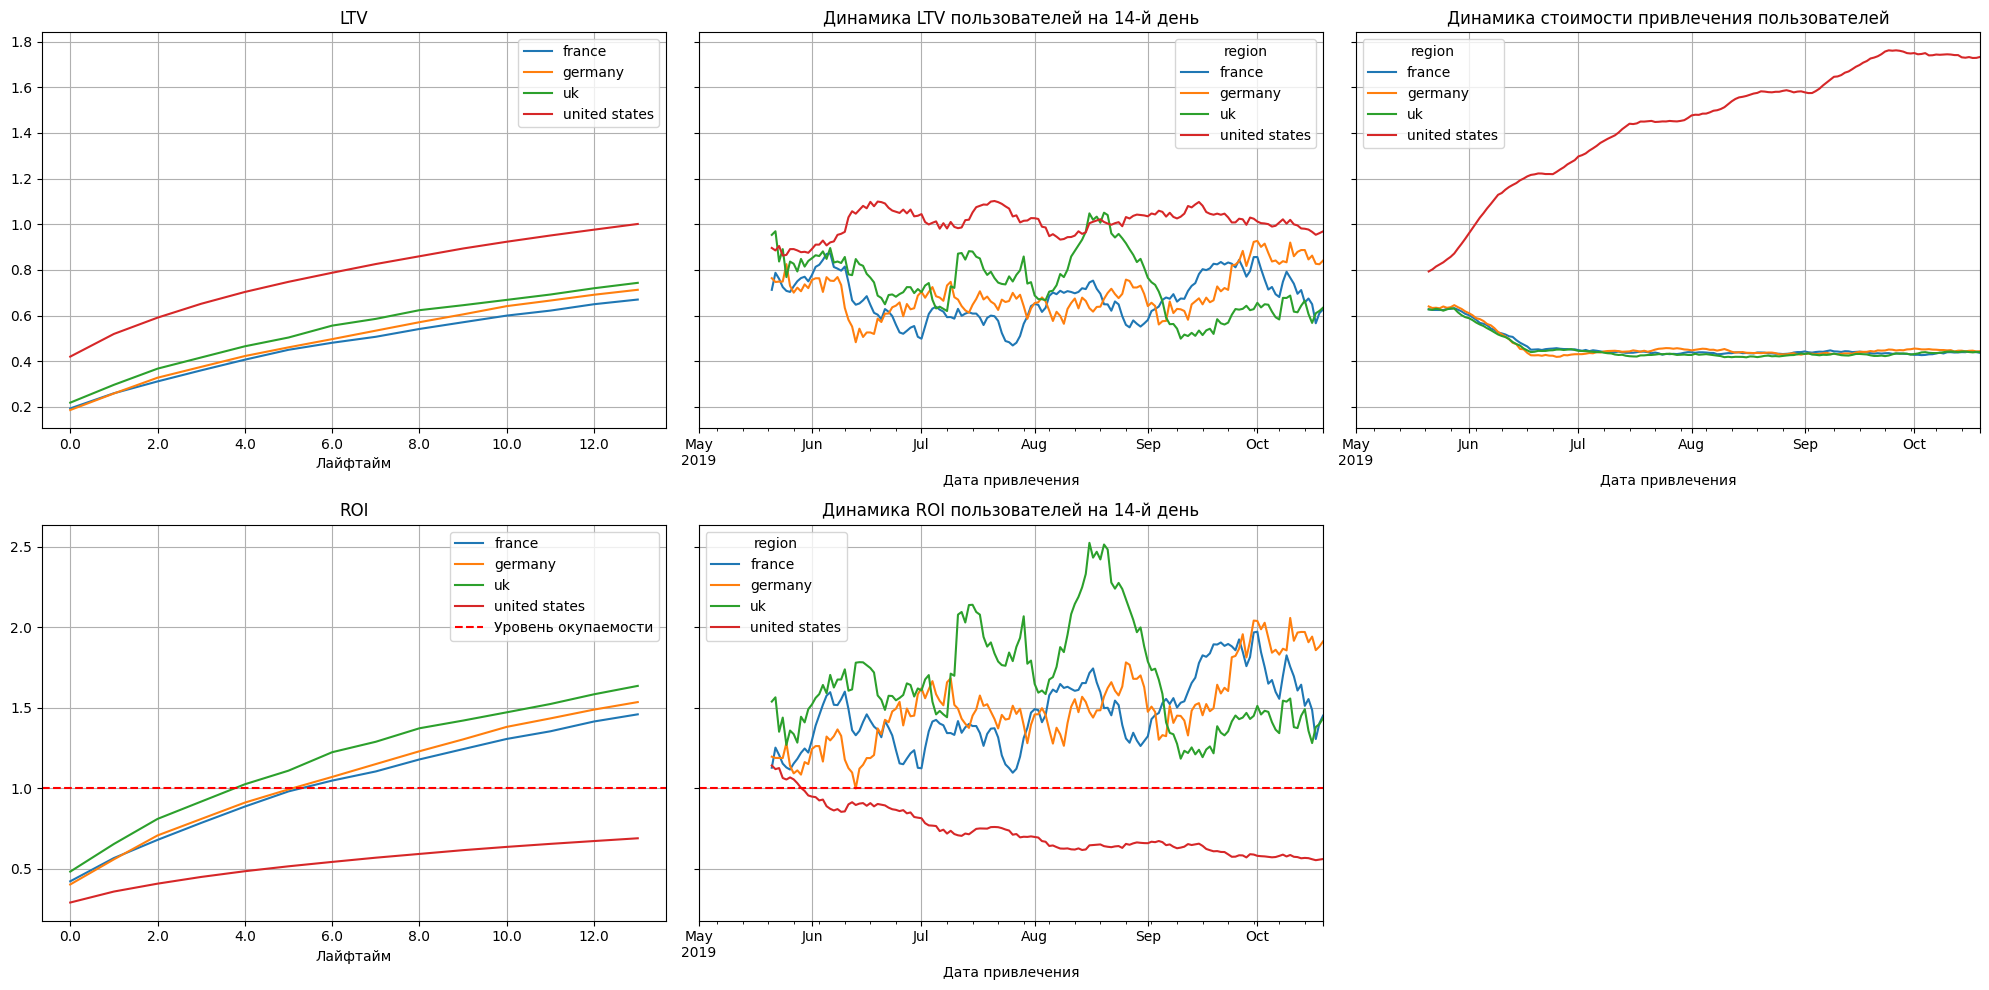

In [37]:
# Проанализируйте окупаемость рекламы с разбивкой по странам.
# Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dims = ['region']
# считаем LTV и ROI

profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

<p>Вообще по графику видно, что LTV у американцев растет быстрее всех, но не так стремительно как затраты. Причем из всех стран не окупаются лишь они.
<p>По всем остальным странам - все в порядке: LTV растет, а стоимость привлечения сначало падает, а потом остается стабильной</p>

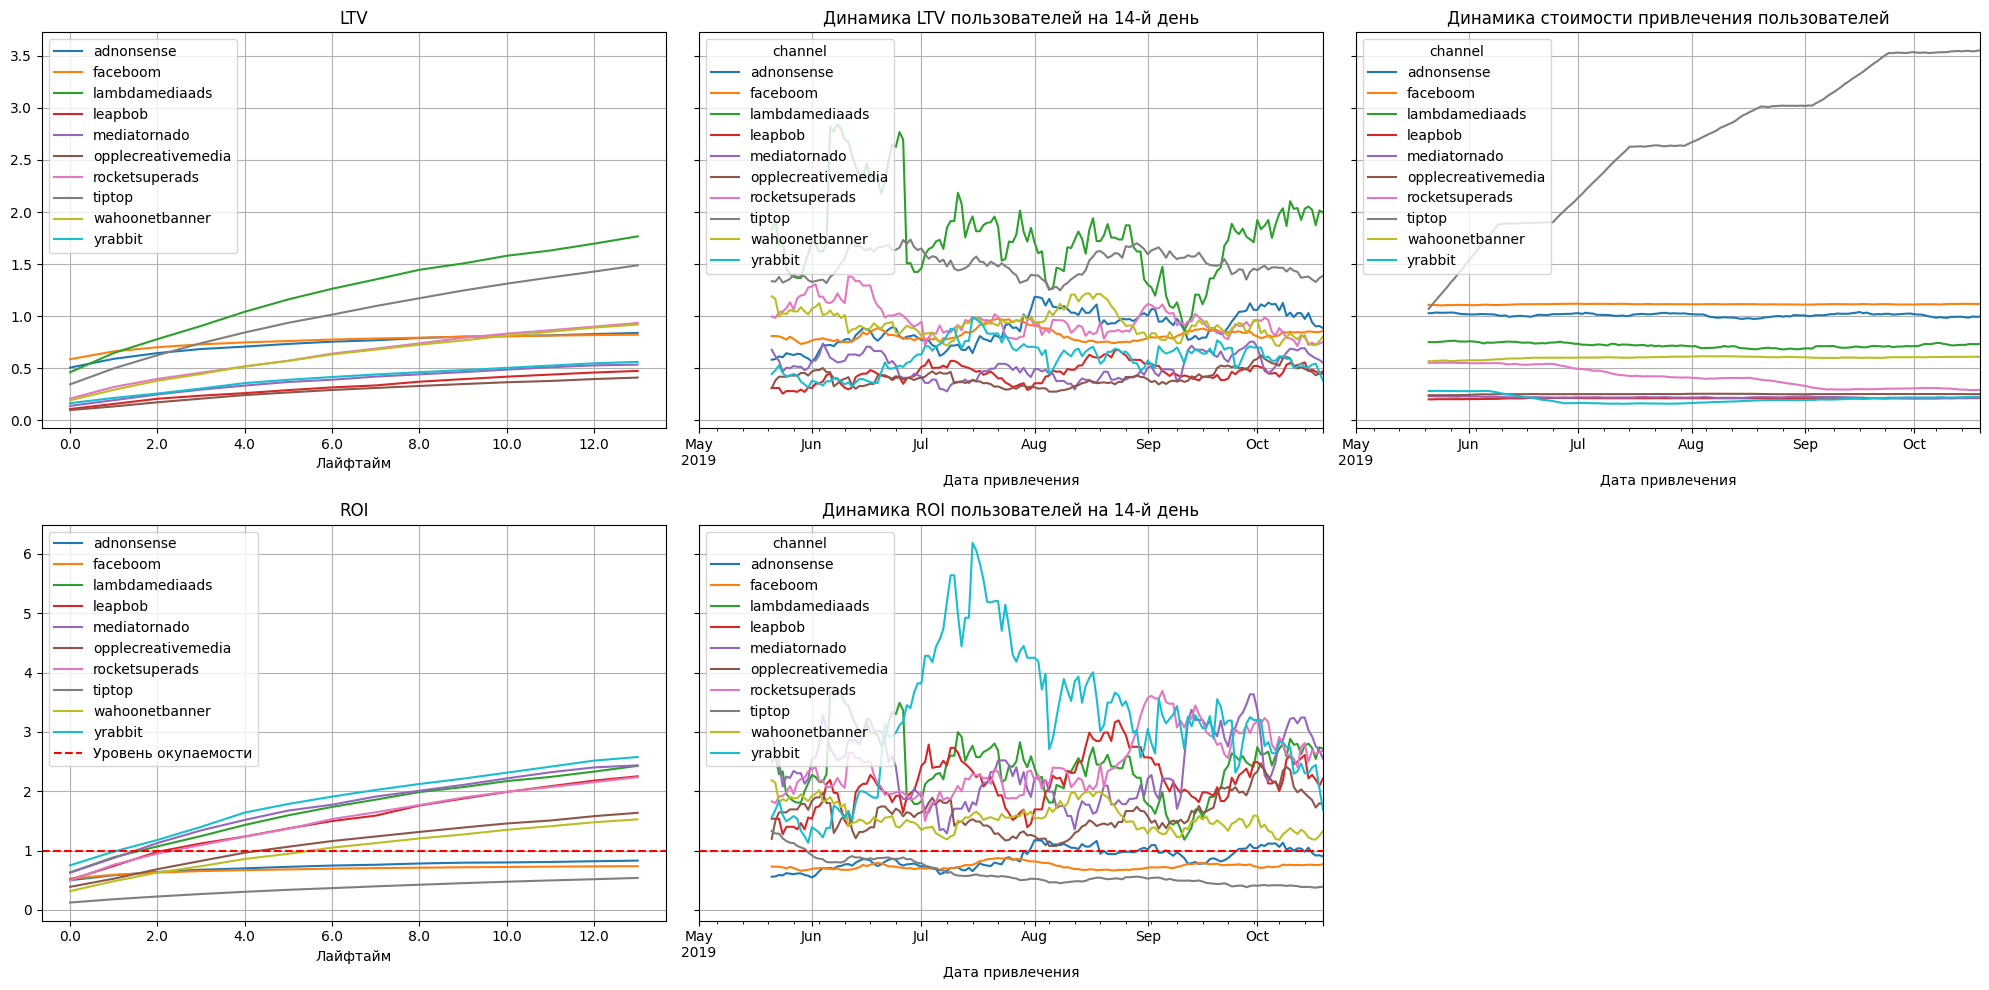

In [38]:
# Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.
# Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI
dims = ['channel']
# считаем LTV и ROI
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

<p>Затраты на  tiptop очень нестабильны, что заметно по графику выше, а также не окупается еще adnonsense и faceboom.</p> 
<p>Также, yrabbit, rocketsuperads, mediatornado - каналы LtV которых растет вместе с их оккупаемостью, а затраты на них либо остаются фиксированными, либо падают.</p>

2024-05-01 19:27:20,677 - INFO - США


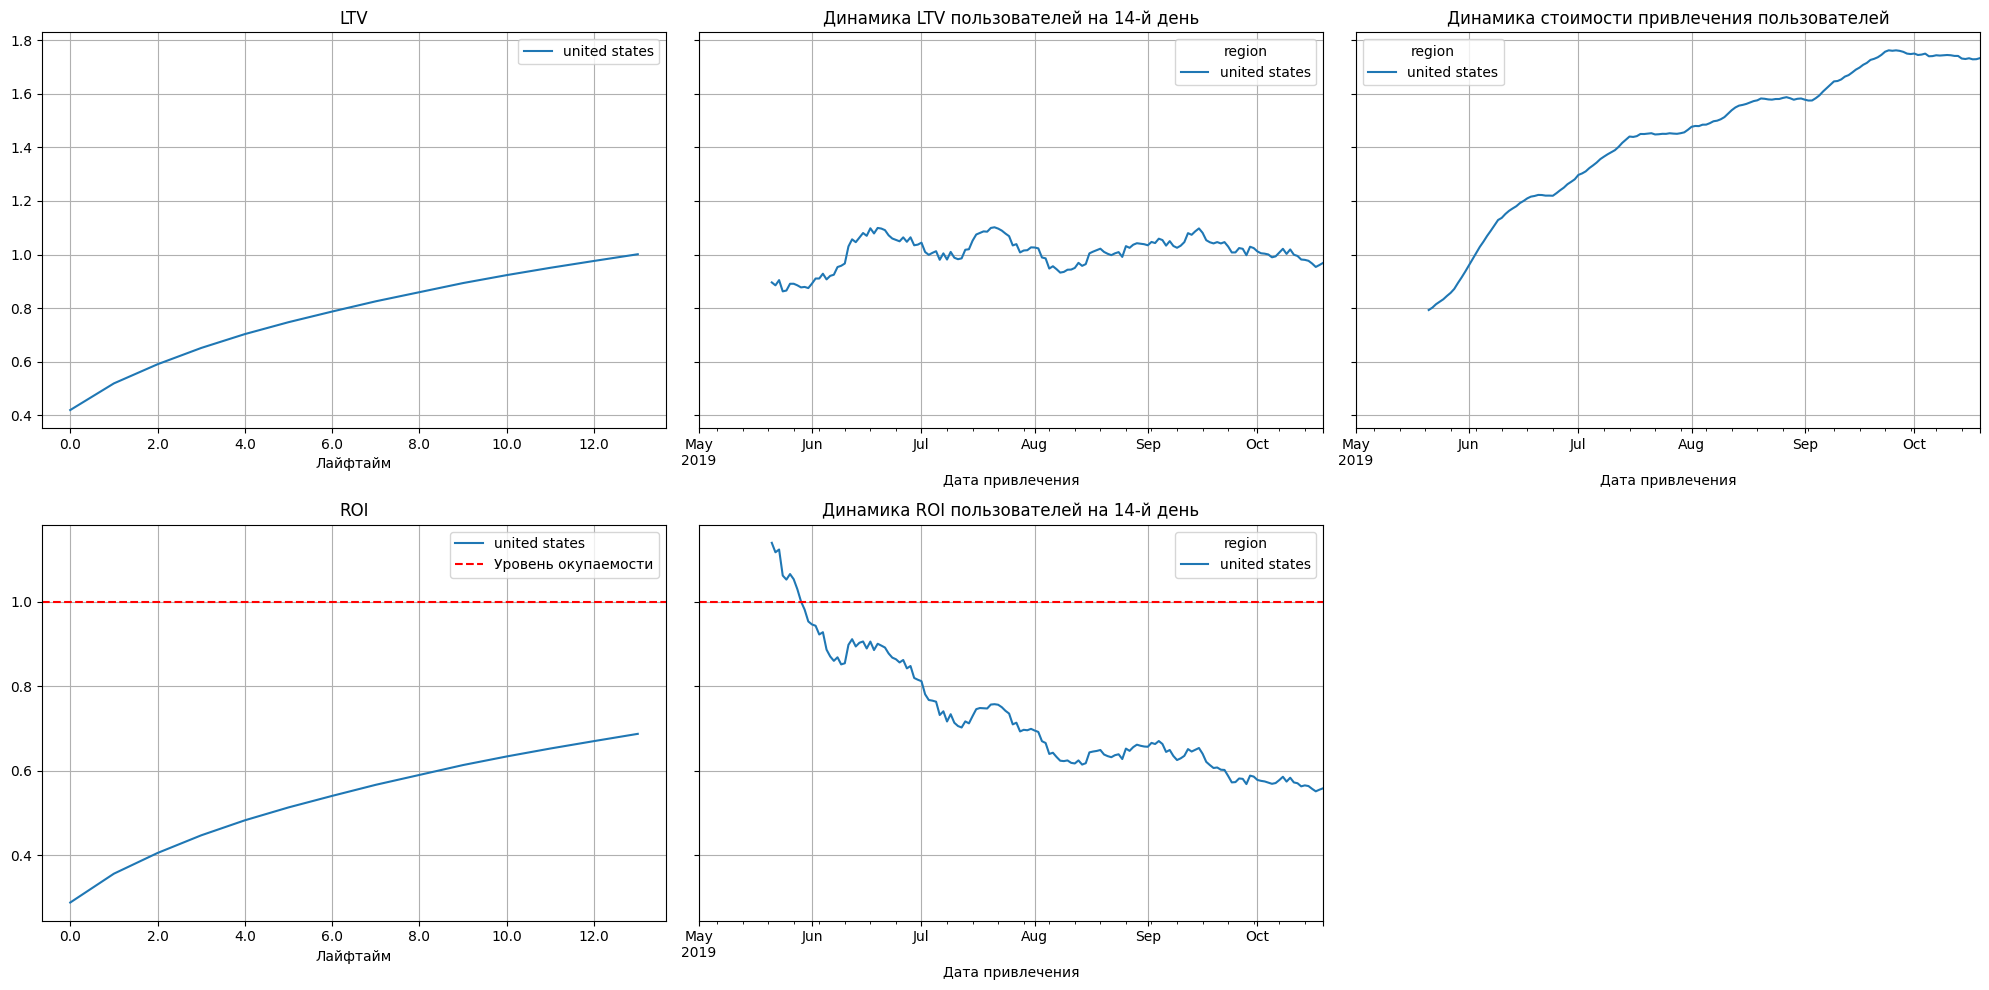

2024-05-01 19:27:23,180 - INFO - европа


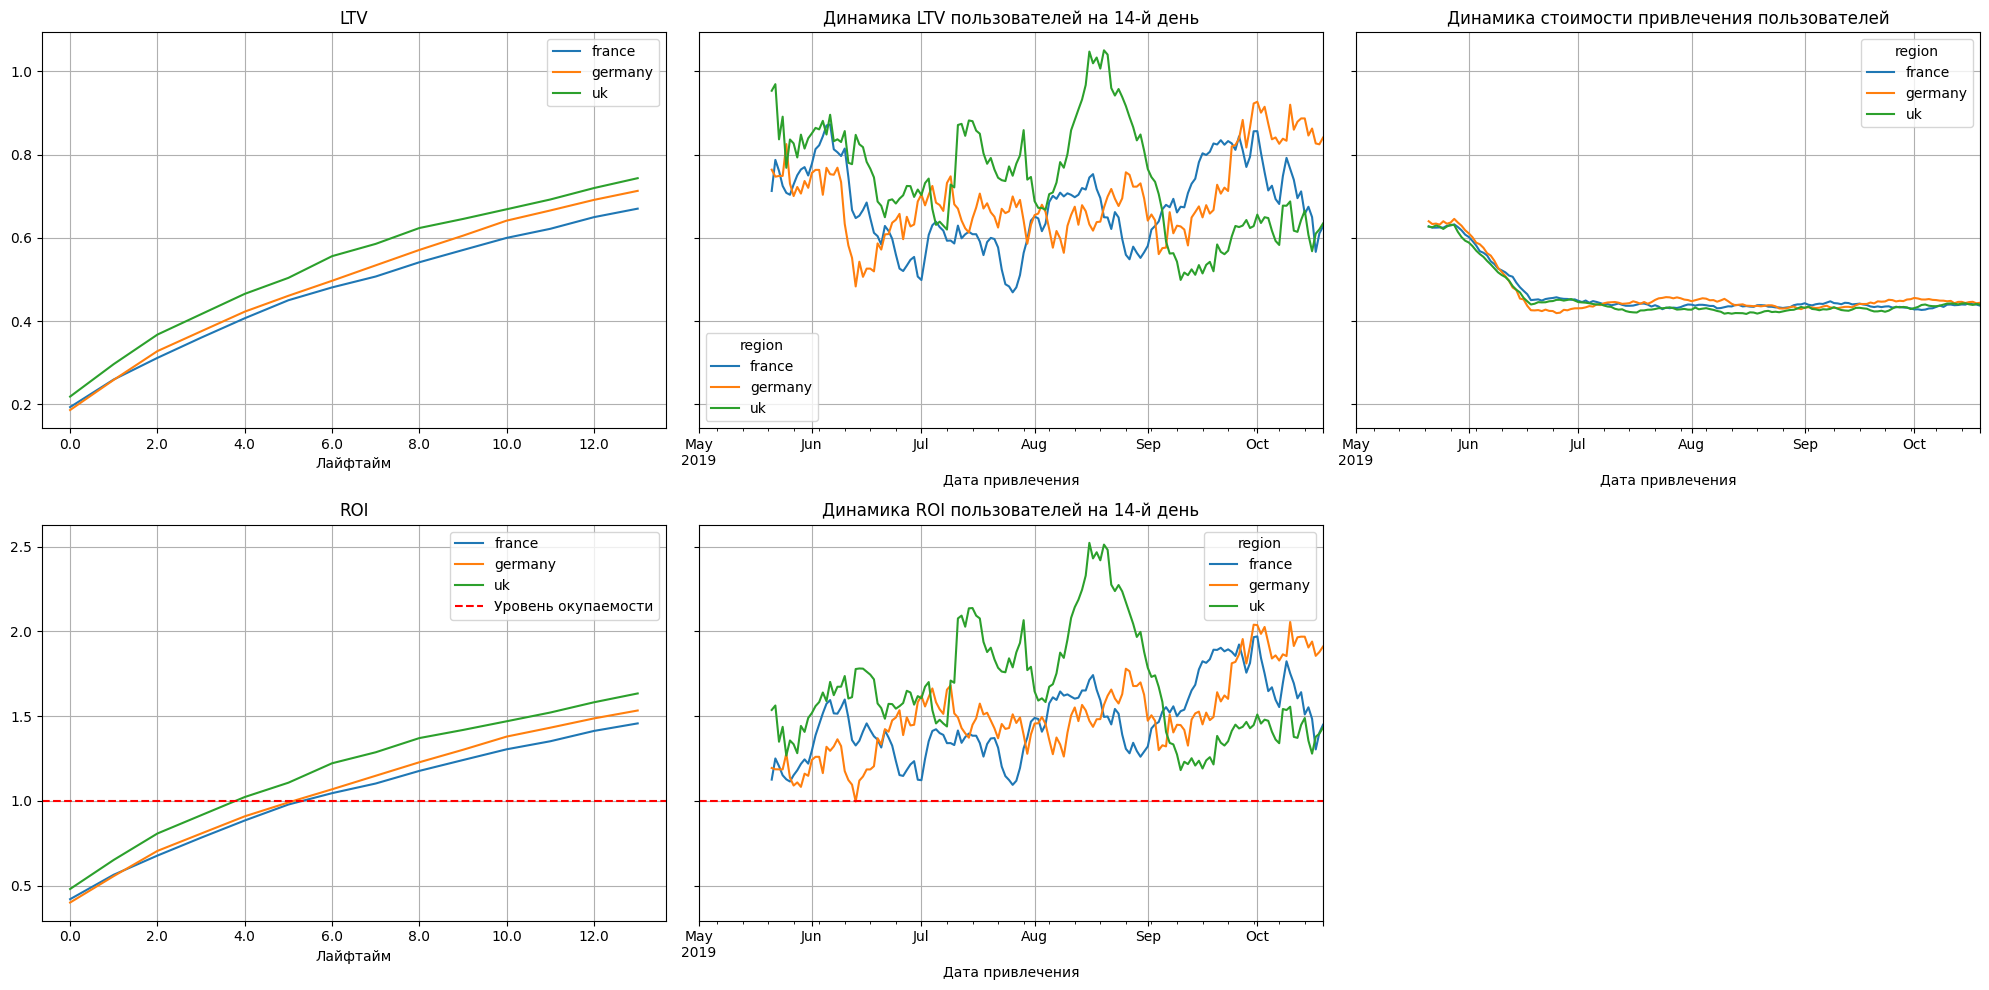

In [39]:
# было бы интересно посмотреть например на бизнес-показатели (графики) в разрезе США-Европа
logging.info('США')
dims = ['region']
# считаем LTV и ROI
profiles_usa = profiles.query('region == "united states"')
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

logging.info('европа')
dims = ['region']
# считаем LTV и ROI
profiles_eu = profiles.query('region != "united states"')
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)


Подтвердили предыдущий вывод, что пользователи из США не окупаются

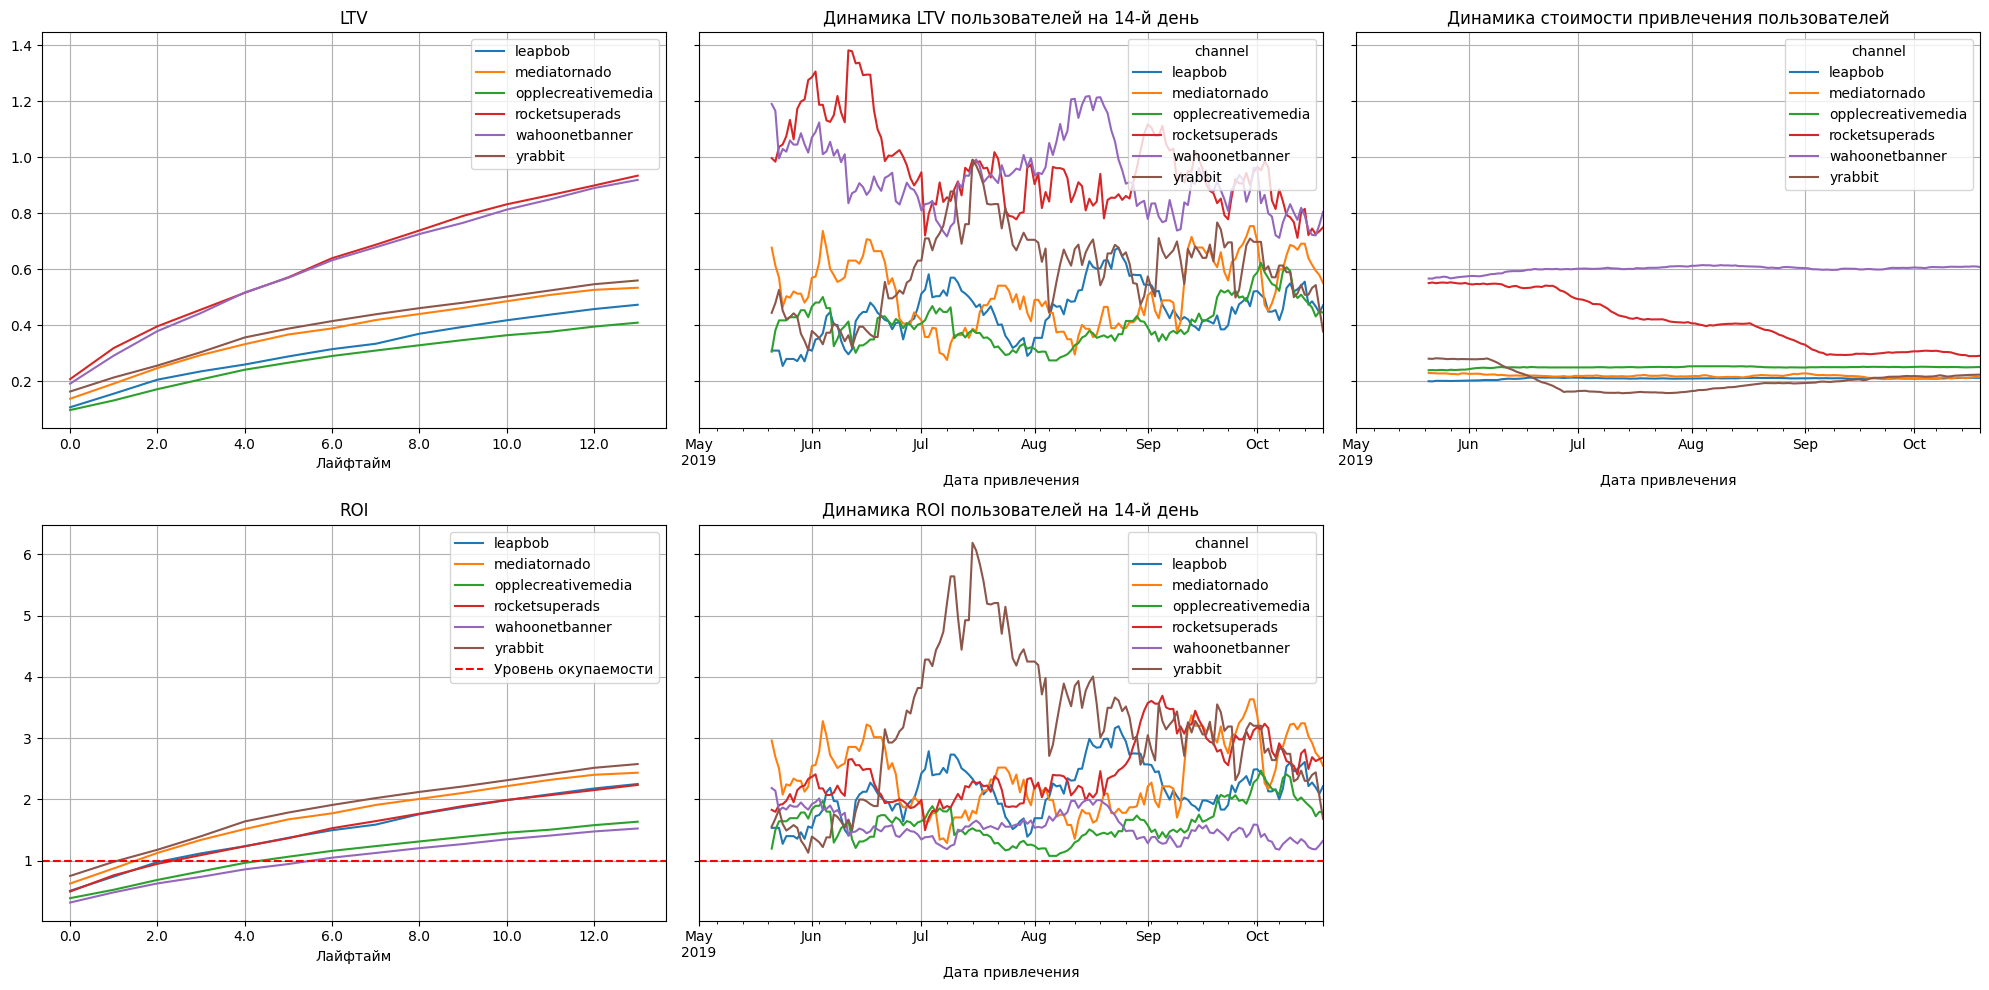

In [40]:
# попробовать посмотреть на общие показатели без трех лидеров по САС в кампании

profiles= profiles.query('channel not in @liders_cac')
dims = ['channel']
# считаем LTV и ROI
profiles['dt'] = pd.to_datetime(profiles['dt'])
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dims
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

Исключив лидеров по CAC, видим, что остальные каналы окупаются.

<p><b><i>Вывод</i></b></p>

<p><i>Причины неэффективности привлечения пользователей.</i></p>

- Пользователи из США удерживаются хуже всего - а между прочим, оттуда большинство платящих пользователей, а также самая большая коверсия идет из США. Стоит также добавить, что затраты на их привлечение слишком большие. Ну и вообще, они не окупаются, в отличии от остальных пользователей.

- Интересно заметить, что плохо удерживаются пользователи, привлеченные из tiptop, faceboom, adnonsense - а это самые дорогие каналы привлечения - затраты на них постаяно растут.

- Из графикоф можно предположить, что не окупаются пользователи продукции apple - стоимость их привлечения растет быстрее чем выручка от них. Пользователи pk - плохо конвертируются, по сравнению со всеми остальными, хотя окупаются лучше всех.

<p><i>Рекомендации для отдела маркетинга.</i></p>

- Пересмотреть бюджет на рекламу, может стоит отказаться от самых дорогих каналов: tiptop, faceboom, adnonsense - и посмотреть еще варианты: yrabbit, rocketsuperads, mediatornado.

- Переориентироваться на европейский рынок

- Обратить внимание на пользователей pk, а не яблочной продукции

